## K-Means

### Data Import

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random as rd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [16]:
#reading each xlsx and changing columns to match to then concat
df2014 = pd.read_excel('data/ttc-streetcar-delay-data-2014.xlsx')
df2015 = pd.read_excel('data/ttc-streetcar-delay-data-2015.xlsx')
df2016 = pd.read_excel('data/ttc-streetcar-delay-data-2016.xlsx')
df2017 = pd.read_excel('data/ttc-streetcar-delay-data-2017.xlsx')
df2018 = pd.read_excel('data/ttc-streetcar-delay-data-2018.xlsx')
df2019 = pd.read_excel('data/ttc-streetcar-delay-data-2019.xlsx')
df2020 = pd.read_excel('data/ttc-streetcar-delay-data-2020_final.xlsx').rename(columns={'Delay':'Min Delay',
                                                                                  'Gap':'Min Gap'})
df2021 = pd.read_excel('data/ttc-streetcar-delay-data-jan-2021-to-august-2021.xlsx').rename(columns={'Bound':'Direction',
                                                                                               'Date':'Report Date',
                                                                                               'Line':'Route'})

df2014['Time'] = pd.to_datetime(df2014['Time'], format='%H:%M:%S').dt.time
df2015['Time'] = pd.to_datetime(df2015['Time'], format='%H:%M:%S').dt.time
df2016['Time'] = pd.to_datetime(df2016['Time'], format='%H:%M:%S').dt.time
df2017['Time'] = pd.to_datetime(df2017['Time'], format='%H:%M:%S').dt.time
df2018['Time'] = pd.to_datetime(df2018['Time'], format='%H:%M:%S').dt.time
df2019['Time'] = pd.to_datetime(df2019['Time'], format='%H:%M:%S').dt.time
df2020['Time'] = pd.to_datetime(df2020['Time'], format='%H:%M:%S').dt.time
df2021['Time'] = pd.to_datetime(df2021['Time'], format='%H:%M:%S').dt.time

frames = [df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021]
df = pd.concat(frames)

In [17]:
df = df.rename(columns={'Report Date':'Report_Date','Min Delay':'Min_Delay','Min Gap':'Min_Gap',
                       'Round Time':'Round_Time'})

### Removing NAs

In [18]:
#summing na values
df.isna().sum()

Report_Date      0
Route            2
Time             0
Day              0
Location        21
Incident         0
Min_Delay        3
Min_Gap          5
Direction       98
Vehicle        503
Round_Time       0
dtype: int64

In [19]:
#removing vehicle as a column
df = df.drop('Vehicle', axis=1)

In [20]:
#removing na values
df = df.dropna()
df

Report_Date Route      Time       Day                        Location  \
0     2014-01-02   505  06:31:00  Thursday         Dundas and Roncesvalles   
1     2014-01-02   504  12:43:00  Thursday                   King and Shaw   
2     2014-01-02   501  14:01:00  Thursday       Kingston road and Bingham   
3     2014-01-02   504  14:22:00  Thursday  King St. and Roncesvalles Ave.   
4     2014-01-02   504  16:42:00  Thursday               King and Bathurst   
...          ...   ...       ...       ...                             ...   
1012  2021-01-31   512  22:10:00    Sunday                     GUNN'S LOOP   
1013  2021-01-31   501  22:43:00    Sunday             QUEEN AND BROADVIEW   
1014  2021-01-31   504  00:15:00    Sunday                KING AND SPADINA   
1016  2021-01-31   501  00:46:00    Sunday                QUEEN AND CHURCH   
1017  2021-01-31   510  01:23:00    Sunday             SPADINA AND COLLEGE   

                 Incident  Min_Delay  Min_Gap Direction Round_Time  
0     Late Leaving Garage        4.0      8.0       E/B   06:30:00  
1      Utilized Off Route       20.0     22.0       E/B   12:30:00  
2                 Held By       13.0     19.0       W/B   14:00:00  
3           Investigation        7.0     11.0       W/B   14:30:00  
4      Utilized Off Route        3.0      6.0       E/B   16:30:00  
...                   ...        ...      ...       ...        ...  
1012           Mechanical        5.0     10.0         E   22:00:00  
1013   Emergency Services       11.0     21.0         W   22:30:00  
1014           Mechanical        3.0      8.0         W   00:30:00  
1016              Held By       13.0     23.0         W   01:00:00  
1017             Cleaning       12.0     24.0         N   01:30:00  

[8957 rows x 10 columns]

### Datetime continuous

In [21]:
from datetime import timedelta

time_in_minutes = []
time_in_hours = []

for time in df['Time']:
    delta = timedelta(hours=int(time.strftime('%H')), 
                      minutes=int(time.strftime('%M')), 
                      seconds=int(time.strftime('%S')))
    total_seconds = delta.total_seconds()
    time_in_minutes.append(total_seconds/60)
    time_in_hours.append(total_seconds/60/60)
    
df['Time_in_minutes'] = time_in_minutes
df['Time_in_hours'] = time_in_hours

### K-Means (day as dummy variable)

In [22]:
def clean_text(text):
    text = text.lower()
    text = text.replace(" ", "_")
    return text

df['Location'] = df['Location'].astype(str).apply(clean_text)
df['Incident'] = df['Incident'].astype(str).apply(clean_text)

In [23]:
cat_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location', 'Incident', 'Min_Gap'], axis=1)
cat_data

Day
0     Thursday
1     Thursday
2     Thursday
3     Thursday
4     Thursday
...        ...
1012    Sunday
1013    Sunday
1014    Sunday
1016    Sunday
1017    Sunday

[8957 rows x 1 columns]

In [24]:
#encoded df
kmeans_dummy = df

for cat in cat_data:
    dummies = pd.get_dummies(cat_data[cat])
    kmeans_dummy = pd.concat([kmeans_dummy, dummies], axis=1)
    kmeans_dummy = kmeans_dummy.drop(cat, axis=1)

kmeans_dummy = kmeans_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Location', 'Incident', 'Time_in_minutes',
                     'Direction', 'Min_Gap'], axis=1)

kmeans_dummy['Min_Delay'] = (kmeans_dummy['Min_Delay'] - kmeans_dummy['Min_Delay'].min()) / (kmeans_dummy['Min_Delay'].max() - kmeans_dummy['Min_Delay'].min())
kmeans_dummy['Time_in_hours'] = (kmeans_dummy['Time_in_hours'] - kmeans_dummy['Time_in_hours'].min()) / (kmeans_dummy['Time_in_hours'].max() - kmeans_dummy['Time_in_hours'].min())

kmeans_dummy

Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0      0.006667       0.271716       0       0         0       0         1   
1      0.033333       0.530229       0       0         0       0         1   
2      0.021667       0.584434       0       0         0       0         1   
3      0.011667       0.599027       0       0         0       0         1   
4      0.005000       0.696317       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012   0.008333       0.924253       0       0         0       1         0   
1013   0.018333       0.947186       0       0         0       1         0   
1014   0.005000       0.010424       0       0         0       1         0   
1016   0.021667       0.031967       0       0         0       1         0   
1017   0.020000       0.057679       0       0         0       1         0   

      Tuesday  Wednesday  
0           0          0  
1           0          0  
2           0          0  
3           0          0  
4           0          0  
...       ...        ...  
1012        0          0  
1013        0          0  
1014        0          0  
1016        0          0  
1017        0          0  

[8957 rows x 9 columns]

In [25]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    label = clusterer.predict(kmeans_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(kmeans_dummy, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
kmeans_dummy.groupby(best_label).mean()


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0   0.017697       0.470975     0.0     0.0       0.0     0.0       0.0   
1   0.018102       0.490871     0.0     0.0       0.0     0.0       0.0   
2   0.017233       0.489691     1.0     0.0       0.0     0.0       0.0   
3   0.015840       0.501836     0.0     1.0       0.0     0.0       0.0   
4   0.019396       0.491290     0.0     0.0       0.0     0.0       1.0   
5   0.019421       0.548532     0.0     0.0       1.0     0.0       0.0   
6   0.021980       0.499448     0.0     0.0       0.0     1.0       0.0   

   Tuesday  Wednesday  
0      1.0        0.0  
1      0.0        1.0  
2      0.0        0.0  
3      0.0        0.0  
4      0.0        0.0  
5      0.0        0.0  
6      0.0        0.0

In [26]:
kmeans_dummy.groupby(best_label).describe()

Min_Delay                                                                   \
      count      mean       std  min       25%       50%       75%       max   
0    1541.0  0.017697  0.040561  0.0  0.006667  0.010000  0.016667  0.820000   
1    1374.0  0.018102  0.035851  0.0  0.008333  0.010000  0.016667  0.696667   
2    1438.0  0.017233  0.028982  0.0  0.006667  0.010000  0.016667  0.475000   
3    1341.0  0.015840  0.021328  0.0  0.006667  0.010000  0.016667  0.303333   
4    1300.0  0.019396  0.040328  0.0  0.006667  0.010000  0.016667  1.000000   
5    1068.0  0.019421  0.036138  0.0  0.008333  0.011667  0.016667  0.881667   
6     895.0  0.021980  0.050987  0.0  0.010000  0.013333  0.016667  0.836667   

  Time_in_hours            ... Tuesday      Wednesday                      \
          count      mean  ...     75%  max     count mean  std  min  25%   
0        1541.0  0.470975  ...     1.0  1.0    1541.0  0.0  0.0  0.0  0.0   
1        1374.0  0.490871  ...     0.0  0.0    1374.0  1.0  0.0  1.0  1.0   
2        1438.0  0.489691  ...     0.0  0.0    1438.0  0.0  0.0  0.0  0.0   
3        1341.0  0.501836  ...     0.0  0.0    1341.0  0.0  0.0  0.0  0.0   
4        1300.0  0.491290  ...     0.0  0.0    1300.0  0.0  0.0  0.0  0.0   
5        1068.0  0.548532  ...     0.0  0.0    1068.0  0.0  0.0  0.0  0.0   
6         895.0  0.499448  ...     0.0  0.0     895.0  0.0  0.0  0.0  0.0   

                  
   50%  75%  max  
0  0.0  0.0  0.0  
1  1.0  1.0  1.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0  
5  0.0  0.0  0.0  
6  0.0  0.0  0.0  

[7 rows x 72 columns]

For k = 5 The average silhouette_score is : 0.6147274268553108
For k = 6 The average silhouette_score is : 0.7127521848262105
For k = 7 The average silhouette_score is : 0.8080954823444463
For k = 8 The average silhouette_score is : 0.7808670434939396
For k = 9 The average silhouette_score is : 0.7555763177855263
For k = 10 The average silhouette_score is : 0.733008123017515
For k = 11 The average silhouette_score is : 0.7101949465259992
For k = 12 The average silhouette_score is : 0.6853141543461626
For k = 13 The average silhouette_score is : 0.6554850884947284
For k = 14 The average silhouette_score is : 0.6353700300407608


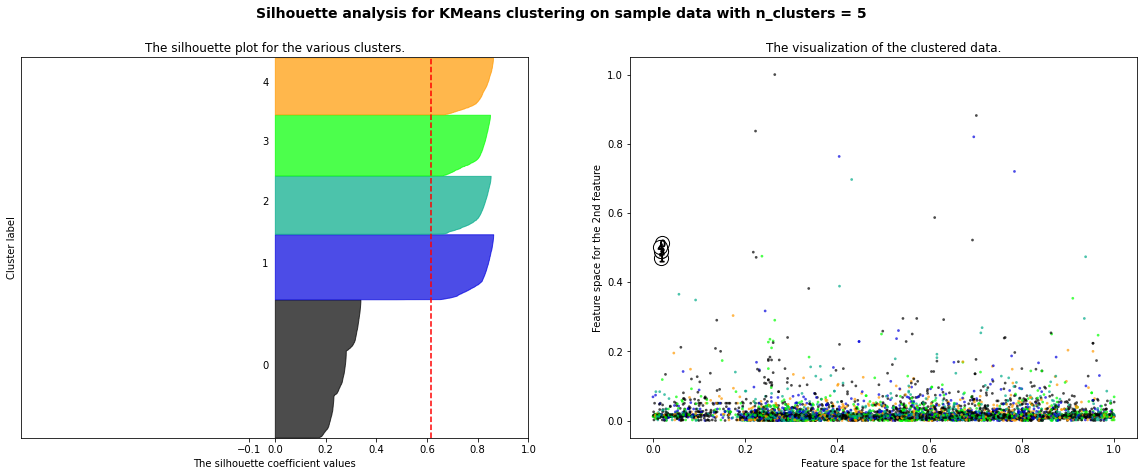

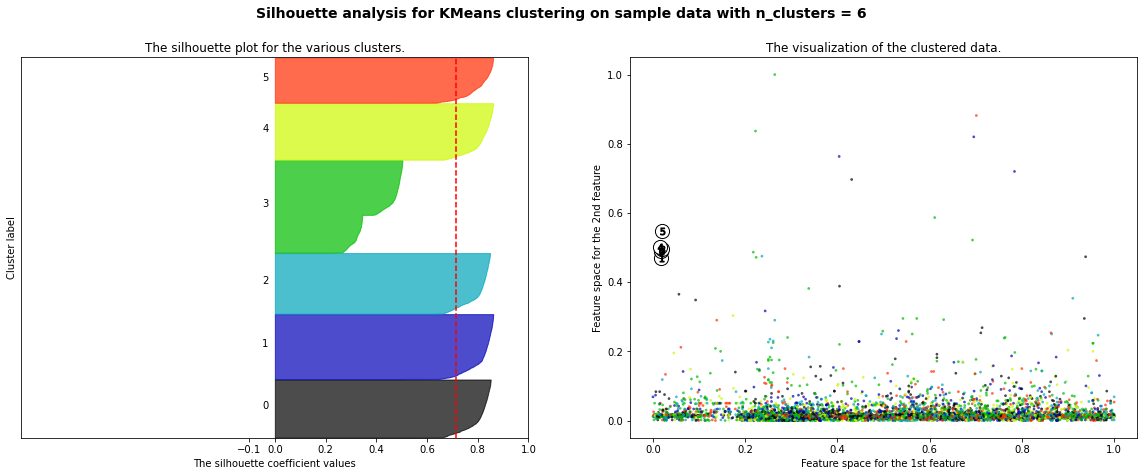

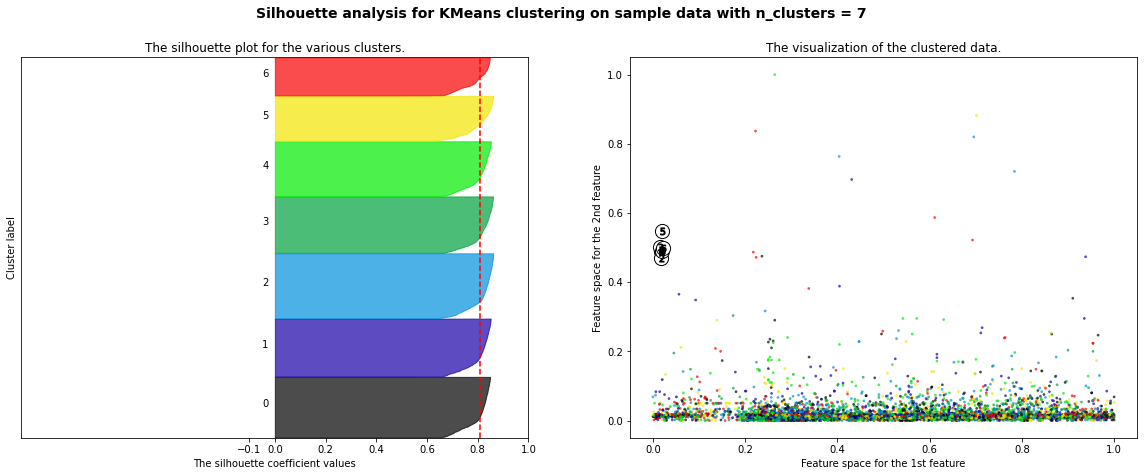

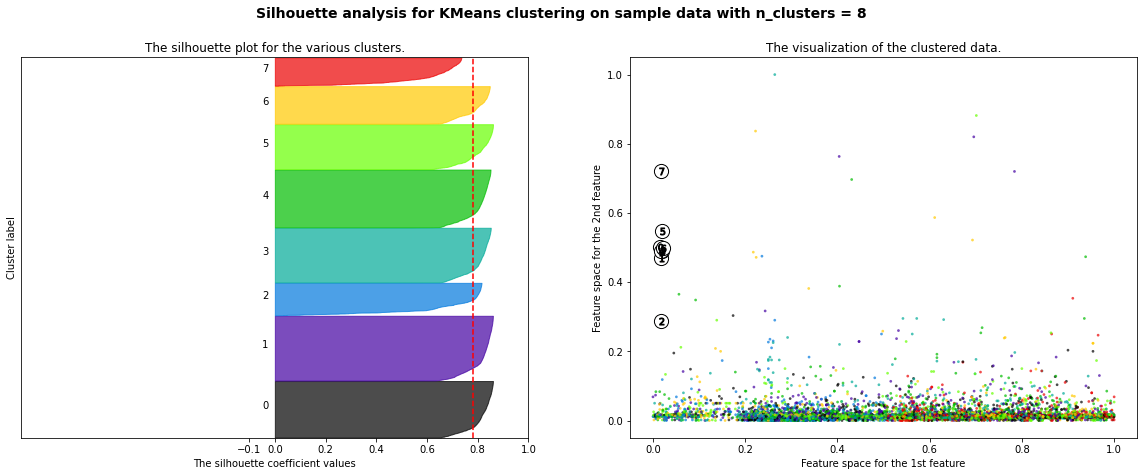

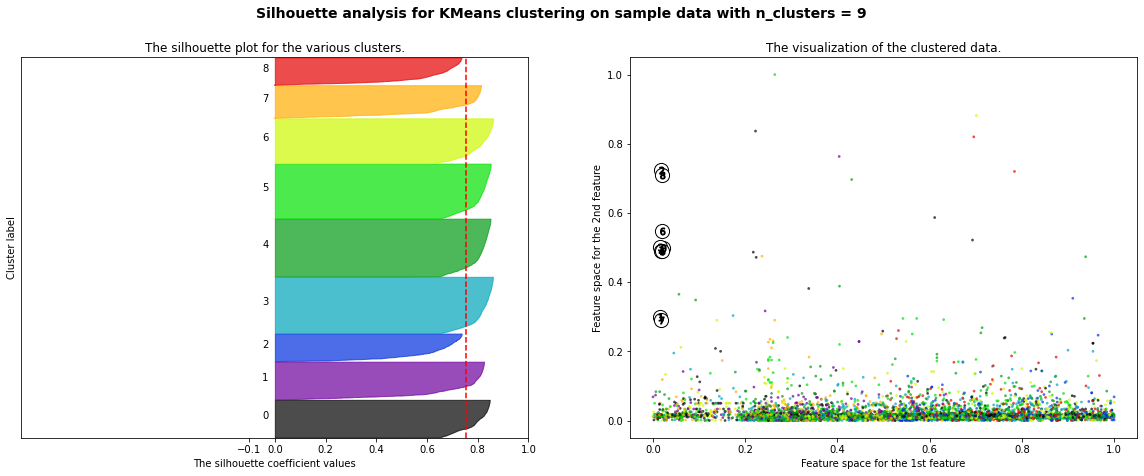

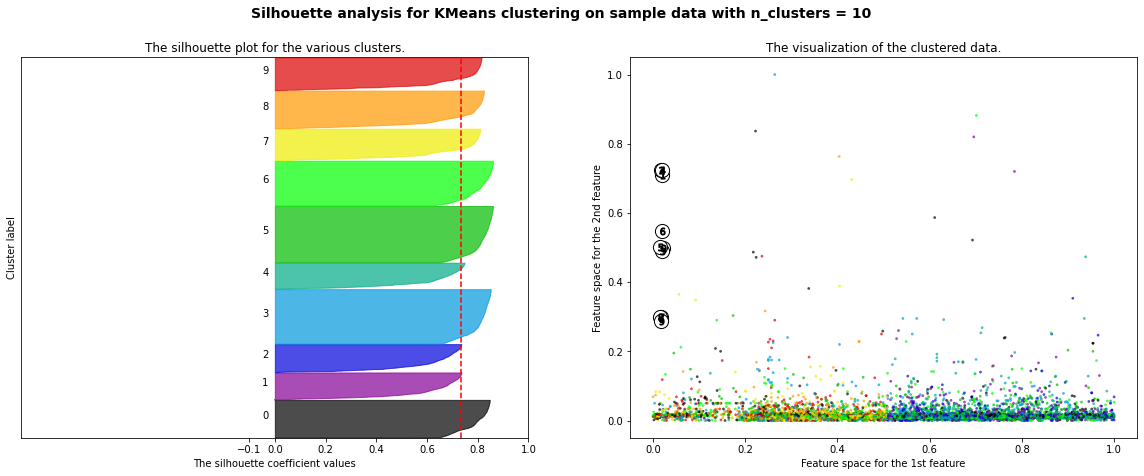

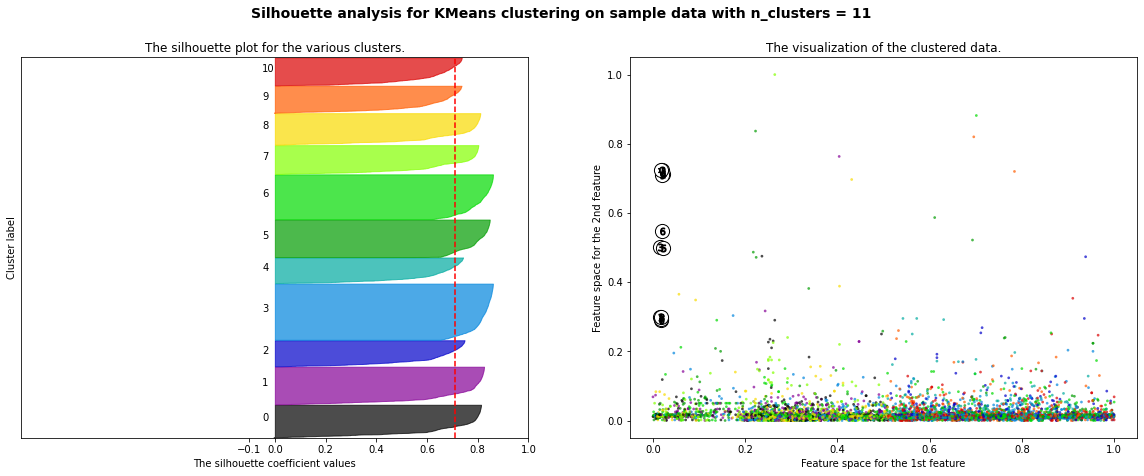

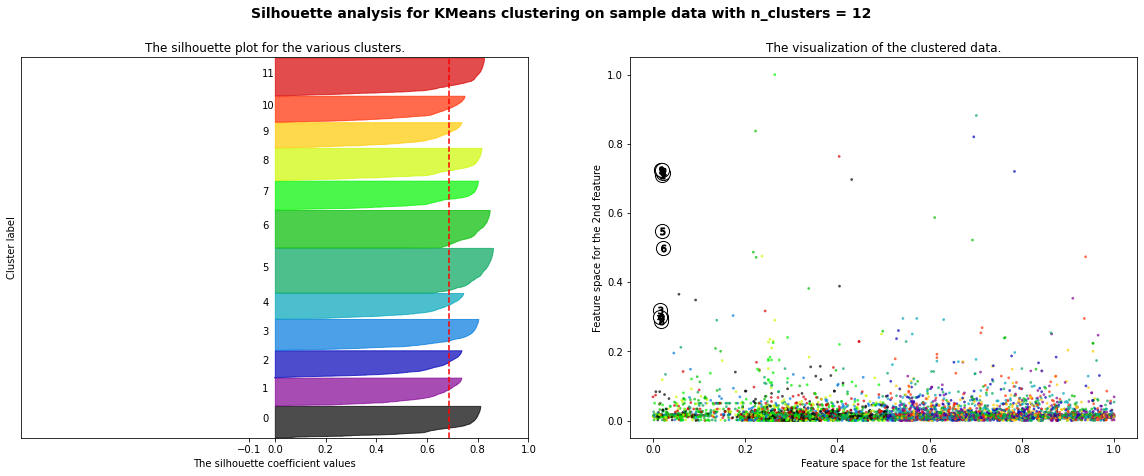

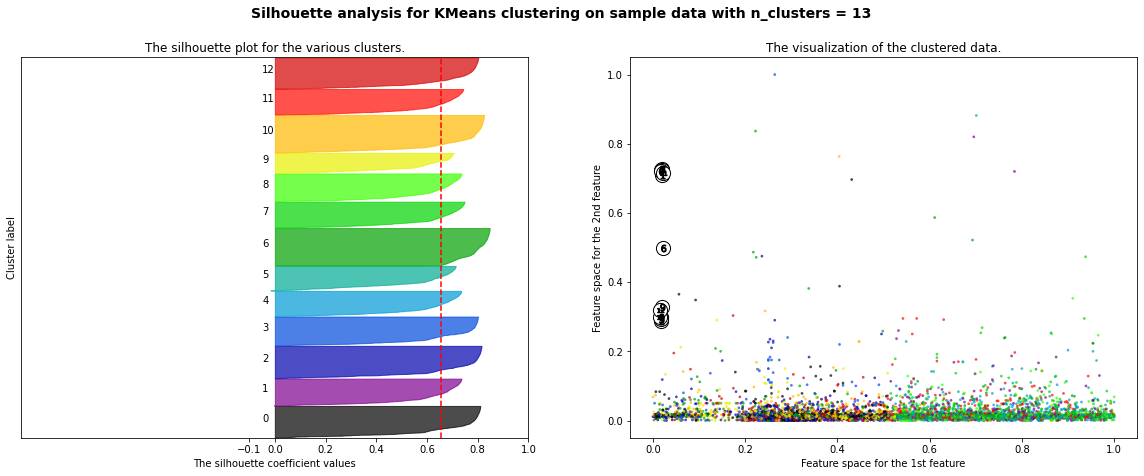

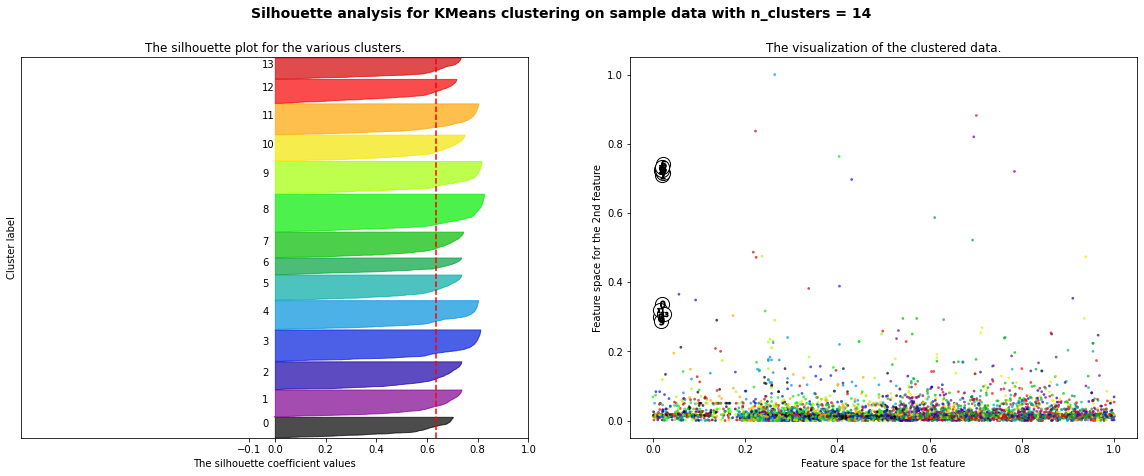

In [27]:
X, y = kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    cluster_labels = clusterer.predict(kmeans_dummy)
    
    silhouette_avg = silhouette_score(kmeans_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(kmeans_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (day as dummy variable)

In [28]:
location_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Incident', 'Min_Gap'], axis=1)
location_data

Location
0            dundas_and_roncesvalles
1                      king_and_shaw
2          kingston_road_and_bingham
3     king_st._and_roncesvalles_ave.
4                  king_and_bathurst
...                              ...
1012                     gunn's_loop
1013             queen_and_broadview
1014                king_and_spadina
1016                queen_and_church
1017             spadina_and_college

[8957 rows x 1 columns]

In [29]:
#encoded df
location_dummy = df

for i in location_data:
    dummies = pd.get_dummies(location_data[i])
    location_dummy = pd.concat([location_dummy, dummies], axis=1)
    location_dummy = location_dummy.drop(cat, axis=1)

location_dummy = location_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Incident', 
                                      'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

location_dummy['Min_Delay'] = (location_dummy['Min_Delay'] - location_dummy['Min_Delay'].min()) / (location_dummy['Min_Delay'].max() - location_dummy['Min_Delay'].min())
location_dummy['Time_in_hours'] = (location_dummy['Time_in_hours'] - location_dummy['Time_in_hours'].min()) / (location_dummy['Time_in_hours'].max() - location_dummy['Time_in_hours'].min())

location_dummy


Min_Delay  Time_in_hours  1st_and_lakeshore  24_th_street_and_lakeshore  \
0      0.006667       0.271716                  0                           0   
1      0.033333       0.530229                  0                           0   
2      0.021667       0.584434                  0                           0   
3      0.011667       0.599027                  0                           0   
4      0.005000       0.696317                  0                           0   
...         ...            ...                ...                         ...   
1012   0.008333       0.924253                  0                           0   
1013   0.018333       0.947186                  0                           0   
1014   0.005000       0.010424                  0                           0   
1016   0.021667       0.031967                  0                           0   
1017   0.020000       0.057679                  0                           0   

      28th_street_and_lakeshore  37th_/_lakeshore  37th_street_and_lakeshore  \
0                             0                 0                          0   
1                             0                 0                          0   
2                             0                 0                          0   
3                             0                 0                          0   
4                             0                 0                          0   
...                         ...               ...                        ...   
1012                          0                 0                          0   
1013                          0                 0                          0   
1014                          0                 0                          0   
1016                          0                 0                          0   
1017                          0                 0                          0   

      40th_/_lakeshore  506_carlton  5th_/_lakeshore  ...  york/_queen  \
0                    0            0                0  ...            0   
1                    0            0                0  ...            0   
2                    0            0                0  ...            0   
3                    0            0                0  ...            0   
4                    0            0                0  ...            0   
...                ...          ...              ...  ...          ...   
1012                 0            0                0  ...            0   
1013                 0            0                0  ...            0   
1014                 0            0                0  ...            0   
1016                 0            0                0  ...            0   
1017                 0            0                0  ...            0   

      york_/_adelaide  york_/_king  york_/_queen  york_and_king  \
0                   0            0             0              0   
1                   0            0             0              0   
2                   0            0             0              0   
3                   0            0             0              0   
4                   0            0             0              0   
...               ...          ...           ...            ...   
1012                0            0             0              0   
1013                0            0             0              0   
1014                0            0             0              0   
1016                0            0             0              0   
1017                0            0             0              0   

      york_and_queen  york_and_queens_quay  york_and_queensquay  \
0                  0                     0                    0   
1                  0                     0                    0   
2                  0                     0                    0   
3                  0                     0                    0   
4                  0                     0 

In [30]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    label = clusterer.predict(location_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(location_dummy, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
location_dummy.groupby(best_label).mean()


Min_Delay  Time_in_hours  1st_and_lakeshore  24_th_street_and_lakeshore  \
0    0.026320       0.293738           0.000000                    0.000000   
1    0.022076       0.832589           0.000000                    0.000000   
2    0.011783       0.547483           0.000000                    0.000000   
3    0.013927       0.445725           0.000000                    0.000000   
4    0.014886       0.524875           0.000000                    0.000000   
5    0.009502       0.391157           0.000000                    0.000000   
6    0.010738       0.378512           0.000000                    0.000000   
7    0.010370       0.542500           0.000000                    0.000000   
8    0.018384       0.271261           0.000000                    0.000000   
9    0.010254       0.338238           0.000000                    0.000000   
10   0.014896       0.327797           0.000000                    0.000000   
11   0.009673       0.325978           0.000000                    0.000000   
12   0.013690       0.543624           0.000000                    0.000000   
13   0.018428       0.571562           0.000413                    0.000413   

    28th_street_and_lakeshore  37th_/_lakeshore  37th_street_and_lakeshore  \
0                    0.000000          0.000000                   0.000000   
1                    0.000000          0.000000                   0.000000   
2                    0.000000          0.000000                   0.000000   
3                    0.000000          0.000000                   0.000000   
4                    0.000000          0.000000                   0.000000   
5                    0.000000          0.000000                   0.000000   
6                    0.000000          0.000000                   0.000000   
7                    0.000000          0.000000                   0.000000   
8                    0.000000          0.000000                   0.000000   
9                    0.000000          0.000000                   0.000000   
10                   0.000000          0.000000                   0.000000   
11                   0.000000          0.000000                   0.000000   
12                   0.000000          0.000000                   0.000000   
13                   0.000413          0.000413                   0.000413   

    40th_/_lakeshore  506_carlton  5th_/_lakeshore  ...  york/_queen  \
0           0.000000     0.000000         0.000000  ...      0.00000   
1           0.000000     0.002121         0.000000  ...      0.00053   
2           0.000000     0.000000         0.000000  ...      0.00000   
3           0.000000     0.000000         0.000000  ...      0.00000   
4           0.000000     0.000000         0.000000  ...      0.00000   
5           0.000000     0.000000         0.000000  ...      0.00000   
6           0.000000     0.000000         0.000000  ...      0.00000   
7           0.000000     0.000000         0.000000  ...      0.00000   
8           0.000000     0.000000         0.000335  ...      0.00000   
9           0.000000     0.000000         0.000000  ...      0.00000   
10          0.000000     0.000000         0.000000  ...      0.00000   
11          0.000000     0.000000         0.000000  ...      0.00000   
12          0.000000     0.000000         0.000000  ...      0.00000   
13          0.000413     0.001240         0.000000  ...      0.00000   

    york_/_adelaide  york_/_king  york_/_queen  york_and_king  york_and_queen  \
0          0.000000     0.000000      0.000000       0.000000        0.000000   
1          0.000000     0.000000      0.000000       0.000530        0.000000   
2          0.000000     0.000000      0.000000       0.000000        0.000000   
3          0.000000     0.000000      0.000000       0.000000        0.000000   
4          0.000000     0.000000      0.000000       0.000000        0.000000   
5          0.000000     0.000000      0.000000       0.000000        0.000000   

In [31]:
location_dummy.groupby(best_label).describe()

Min_Delay                                                              \
       count      mean       std       min       25%       50%       75%   
0      231.0  0.026320  0.078300  0.000000  0.005000  0.013333  0.015000   
1     1886.0  0.022076  0.044327  0.000000  0.008333  0.011667  0.018333   
2      157.0  0.011783  0.008603  0.001667  0.008333  0.010000  0.013333   
3      118.0  0.013927  0.013613  0.001667  0.006667  0.010000  0.015000   
4       88.0  0.014886  0.018576  0.000000  0.008333  0.010000  0.016667   
5      184.0  0.009502  0.005408  0.000000  0.006667  0.008333  0.010000   
6      140.0  0.010738  0.005082  0.000000  0.008333  0.008333  0.013333   
7      108.0  0.010370  0.008198  0.000000  0.006667  0.008333  0.010000   
8     2988.0  0.018384  0.038302  0.000000  0.006667  0.010000  0.016667   
9      131.0  0.010254  0.005023  0.001667  0.008333  0.010000  0.010000   
10      80.0  0.014896  0.022977  0.000000  0.006667  0.008333  0.012083   
11     245.0  0.009673  0.005095  0.000000  0.006667  0.010000  0.010000   
12     182.0  0.013690  0.013828  0.000000  0.006667  0.010000  0.013333   
13    2419.0  0.018428  0.030142  0.000000  0.008333  0.010000  0.016667   

             Time_in_hours            ... young_and_dundas       yoyoma  \
         max         count      mean  ...              75%  max   count   
0   1.000000         231.0  0.293738  ...              0.0  0.0   231.0   
1   0.881667        1886.0  0.832589  ...              0.0  1.0  1886.0   
2   0.068333         157.0  0.547483  ...              0.0  0.0   157.0   
3   0.083333         118.0  0.445725  ...              0.0  0.0   118.0   
4   0.140000          88.0  0.524875  ...              0.0  0.0    88.0   
5   0.028333         184.0  0.391157  ...              0.0  0.0   184.0   
6   0.036667         140.0  0.378512  ...              0.0  0.0   140.0   
7   0.055000         108.0  0.542500  ...              0.0  0.0   108.0   
8   0.836667        2988.0  0.271261  ...              0.0  0.0  2988.0   
9   0.040000         131.0  0.338238  ...              0.0  0.0   131.0   
10  0.125000          80.0  0.327797  ...              0.0  0.0    80.0   
11  0.038333         245.0  0.325978  ...              0.0  0.0   245.0   
12  0.070000         182.0  0.543624  ...              0.0  0.0   182.0   
13  0.586667        2419.0  0.571562  ...              0.0  0.0  2419.0   

                                                 
        mean       std  min  25%  50%  75%  max  
0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
1   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
2   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
3   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
4   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
5   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
6   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
7   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
8   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
9   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
10  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
11  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
12  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
13  0.000413  0.020332  0.0  0.0  0.0  0.0  1.0  

[14 rows x 22864 columns]

For k = 5 The average silhouette_score is : 0.05462348731518101
For k = 6 The average silhouette_score is : 0.06477649996995885
For k = 7 The average silhouette_score is : 0.08950272633868829
For k = 8 The average silhouette_score is : 0.09882710840496191
For k = 9 The average silhouette_score is : 0.11594218190855425
For k = 10 The average silhouette_score is : 0.1285562944822083
For k = 11 The average silhouette_score is : 0.13069283079009342
For k = 12 The average silhouette_score is : 0.14518186149007692
For k = 13 The average silhouette_score is : 0.15155240109092474
For k = 14 The average silhouette_score is : 0.14154481451492532


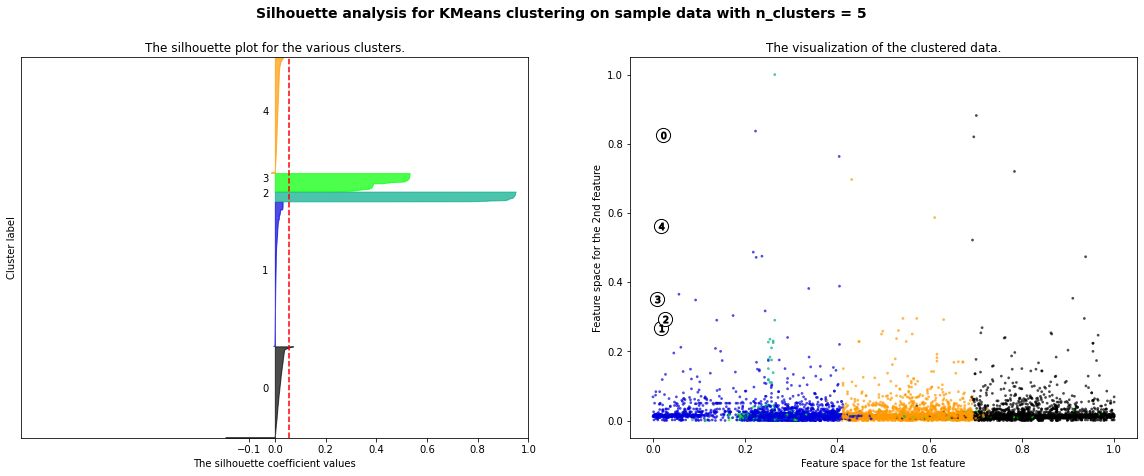

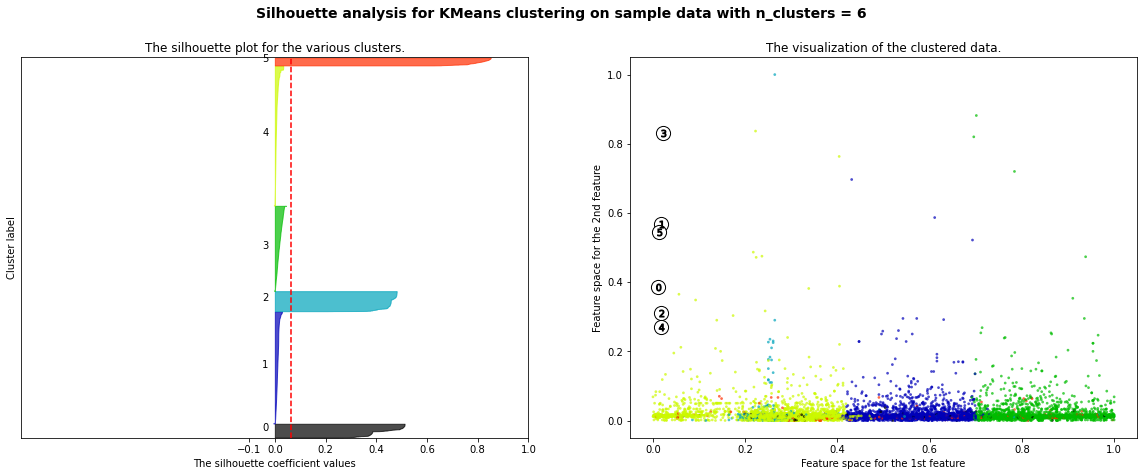

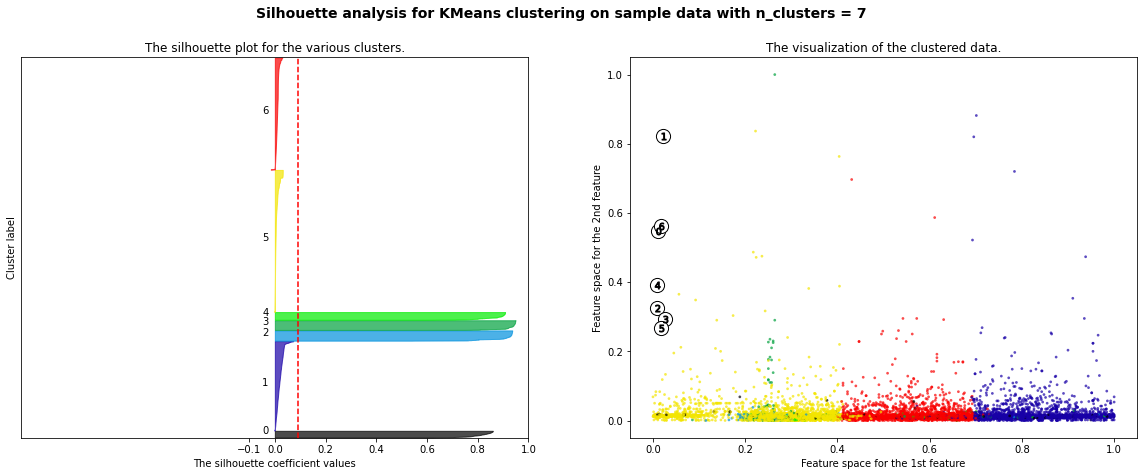

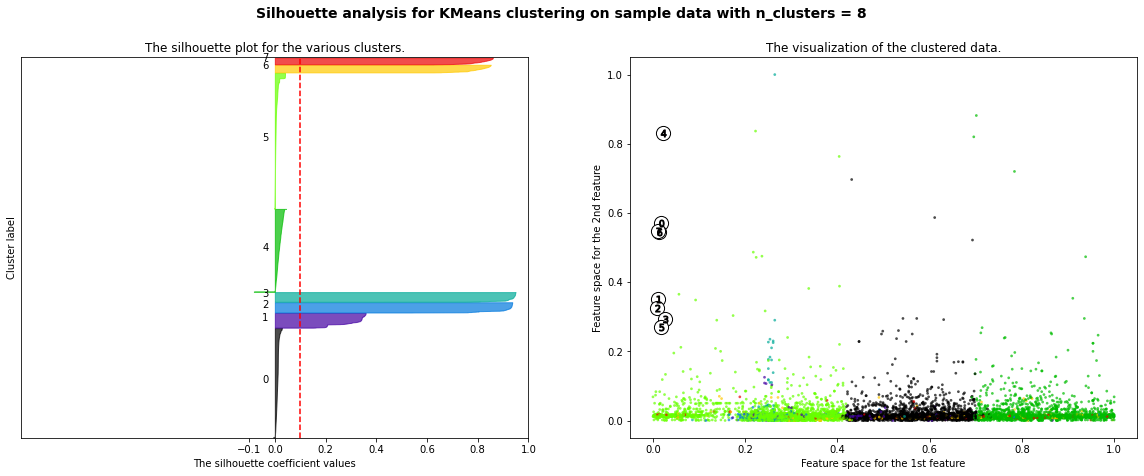

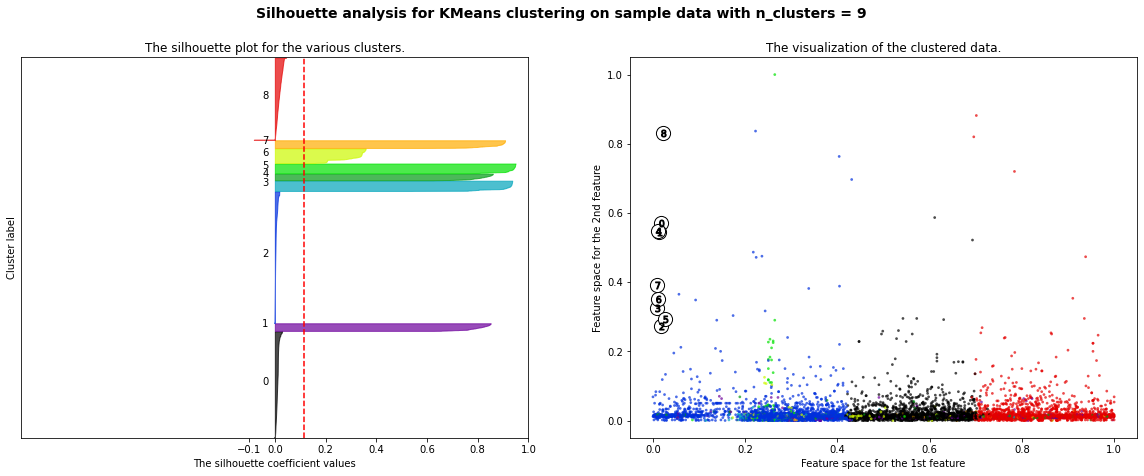

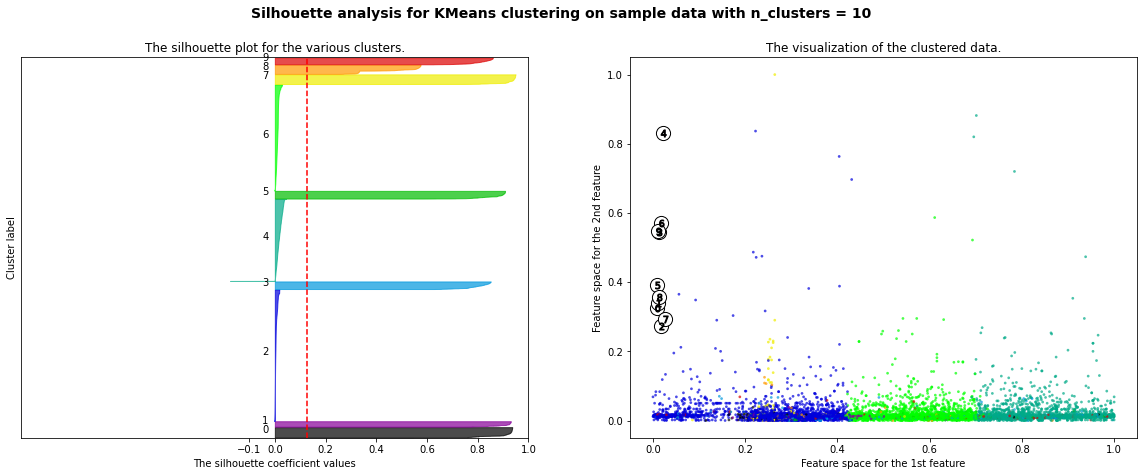

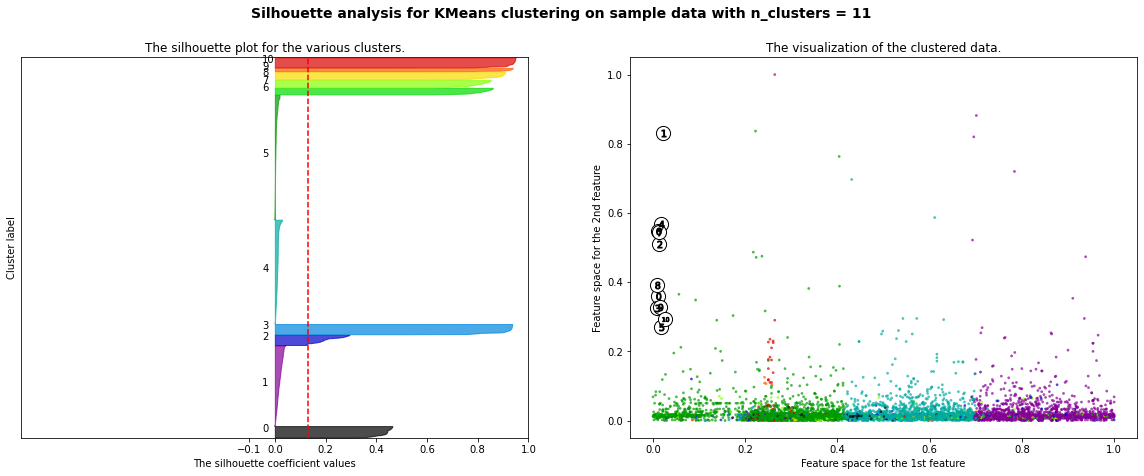

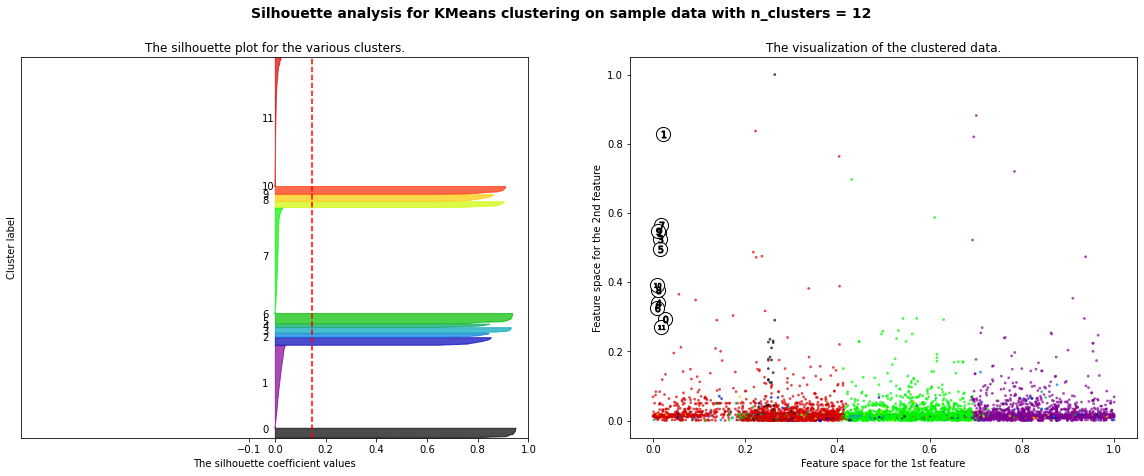

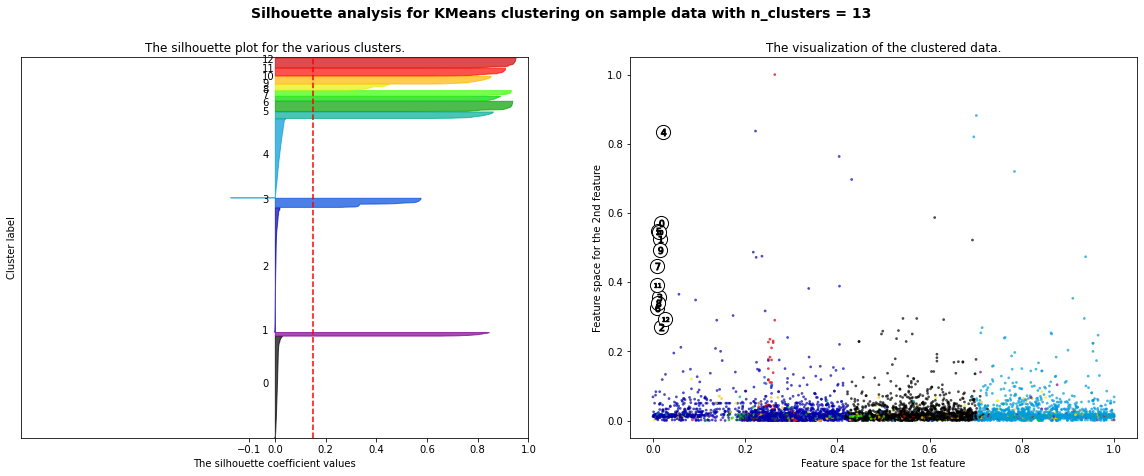

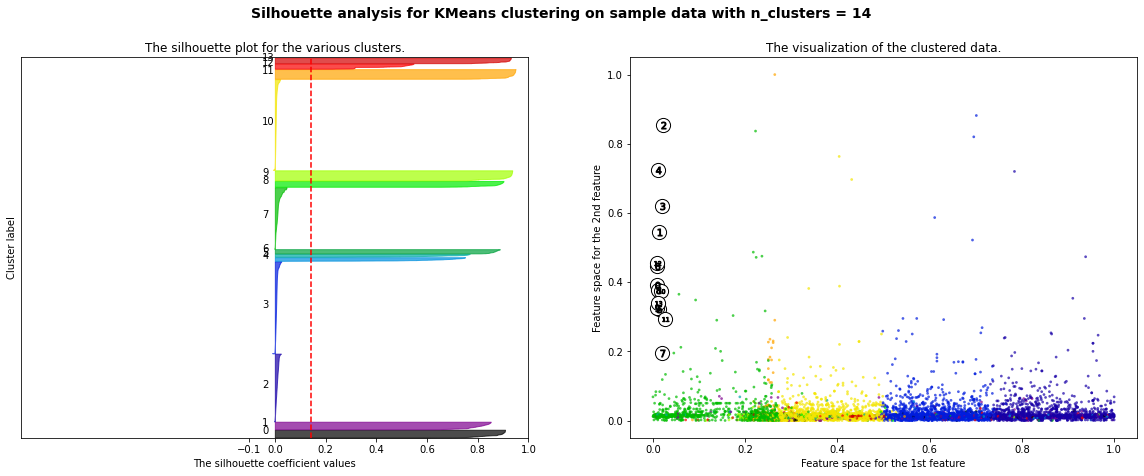

In [32]:
X, y = location_dummy['Time_in_hours'], location_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    cluster_labels = clusterer.predict(location_dummy)
    
    silhouette_avg = silhouette_score(location_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(location_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        location_dummy['Time_in_hours'], location_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (incident as dummy variables)

In [50]:
incident_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location', 'Min_Gap'], axis=1)
incident_data

Incident
0     late_leaving_garage
1      utilized_off_route
2                 held_by
3           investigation
4      utilized_off_route
...                   ...
1012           mechanical
1013   emergency_services
1014           mechanical
1016              held_by
1017             cleaning

[8957 rows x 1 columns]

In [64]:
#encoded df
incident_dummy = df

for i in incident_data:
    dummies = pd.get_dummies(incident_data[i])
    incident_dummy = pd.concat([incident_dummy, dummies], axis=1)
    incident_dummy = incident_dummy.drop(i, axis=1)

incident_dummy = incident_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Day',
                                      'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

incident_dummy['Min_Delay'] = (incident_dummy['Min_Delay'] - incident_dummy['Min_Delay'].min()) / (incident_dummy['Min_Delay'].max() - incident_dummy['Min_Delay'].min())
incident_dummy['Time_in_hours'] = (incident_dummy['Time_in_hours'] - incident_dummy['Time_in_hours'].min()) / (incident_dummy['Time_in_hours'].max() - incident_dummy['Time_in_hours'].min())

incident_dummy


Min_Delay  Time_in_hours  cleaning  collision_-_ttc_involved  diversion  \
0      0.006667       0.271716         0                         0          0   
1      0.033333       0.530229         0                         0          0   
2      0.021667       0.584434         0                         0          0   
3      0.011667       0.599027         0                         0          0   
4      0.005000       0.696317         0                         0          0   
...         ...            ...       ...                       ...        ...   
1012   0.008333       0.924253         0                         0          0   
1013   0.018333       0.947186         0                         0          0   
1014   0.005000       0.010424         0                         0          0   
1016   0.021667       0.031967         0                         0          0   
1017   0.020000       0.057679         1                         0          0   

      emergency_services  general_delay  held_by  investigation  late  \
0                      0              0        0              0     0   
1                      0              0        0              0     0   
2                      0              0        1              0     0   
3                      0              0        0              1     0   
4                      0              0        0              0     0   
...                  ...            ...      ...            ...   ...   
1012                   0              0        0              0     0   
1013                   1              0        0              0     0   
1014                   0              0        0              0     0   
1016                   0              0        1              0     0   
1017                   0              0        0              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
0                       1           0           0         0   
1                       0           0           0         0   
2                       0           0           0         0   
3                       0           0           0         0   
4                       0           0           0         0   
...                   ...         ...         ...       ...   
1012                    0           1           0         0   
1013                    0           0           0         0   
1014                    0           1           0         0   
1016                    0           0           0         0   
1017                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0                   1  
...                     ...            ...       ...                 ...  
1012                      0              0         0                   0  
1013                      0              0         0                   0  
1014                      0              0         0                   0  
1016                      0              0         0                   0  
1017                      0              0         0                   0  

[8957 rows x 18 columns]

In [55]:
# Try various values of k
sil_scores = []
for k in range(2,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(incident_dummy)
    label = clusterer.predict(incident_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(incident_dummy, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
#location_dummy.groupby(best_label).mean()
sil_scores

k  silhouette_score                                              label
0    2          0.473560  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...
1    3          0.560442  [2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...
2    4          0.636556  [3, 2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, ...
3    5          0.697800  [4, 3, 1, 2, 3, 1, 3, 2, 3, 0, 0, 0, 0, 0, 0, ...
4    6          0.728958  [2, 5, 1, 3, 5, 1, 5, 3, 5, 0, 0, 0, 0, 0, 0, ...
5    7          0.754590  [2, 6, 1, 4, 6, 1, 6, 4, 6, 0, 0, 0, 0, 0, 0, ...
6    8          0.776761  [0, 7, 2, 3, 7, 2, 7, 3, 7, 1, 1, 1, 1, 1, 1, ...
7    9          0.793132  [0, 7, 3, 2, 7, 3, 7, 2, 7, 1, 1, 1, 1, 1, 1, ...
8   10          0.706722  [2, 5, 1, 3, 5, 1, 5, 3, 5, 0, 0, 0, 0, 0, 0, ...
9   11          0.718533  [3, 6, 2, 0, 6, 2, 6, 0, 6, 1, 1, 1, 1, 1, 1, ...
10  12          0.724232  [2, 7, 3, 1, 7, 3, 7, 1, 7, 9, 9, 9, 9, 9, 9, ...
11  13          0.728055  [3, 5, 2, 4, 5, 2, 5, 4, 5, 1, 1, 1, 1, 1, 1, ...
12  14          0.703909  [4, 5, 10, 2, 5, 10, 5, 2, 5, 1, 1, 1, 1, 1, 1...

For k = 2 The average silhouette_score is : 0.4735604991301108
For k = 3 The average silhouette_score is : 0.5604421871230411
For k = 4 The average silhouette_score is : 0.6365556950834428
For k = 5 The average silhouette_score is : 0.6977998860054282
For k = 6 The average silhouette_score is : 0.728957929009116
For k = 7 The average silhouette_score is : 0.7545898669358185
For k = 8 The average silhouette_score is : 0.7767610901185578
For k = 9 The average silhouette_score is : 0.7923387178355275
For k = 10 The average silhouette_score is : 0.7067221638924212
For k = 11 The average silhouette_score is : 0.7185333545840009
For k = 12 The average silhouette_score is : 0.7242321400120656
For k = 13 The average silhouette_score is : 0.6993231561422392
For k = 14 The average silhouette_score is : 0.6758125411029952


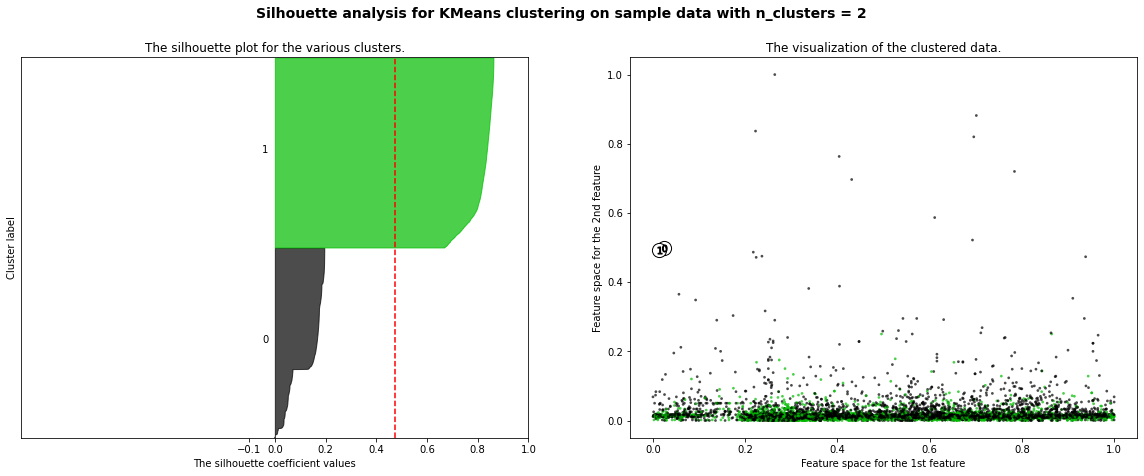

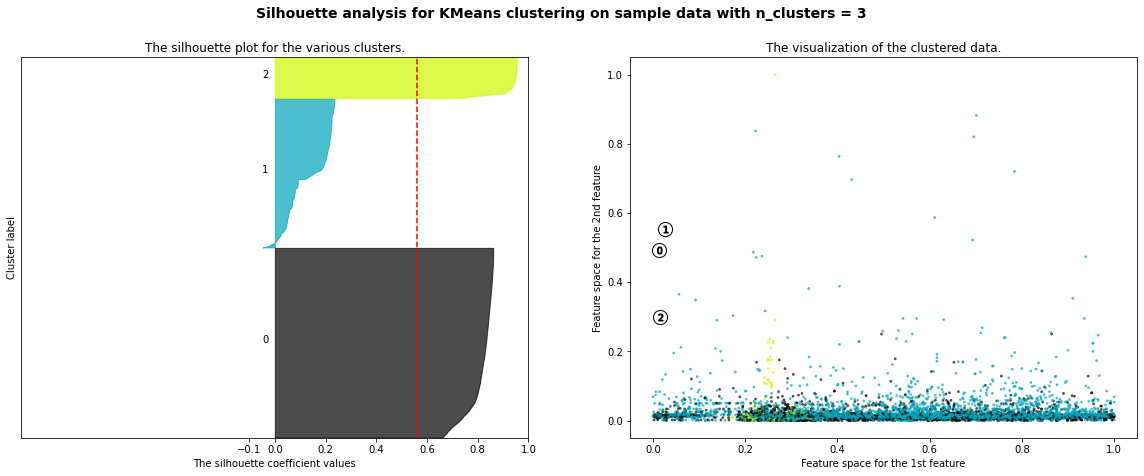

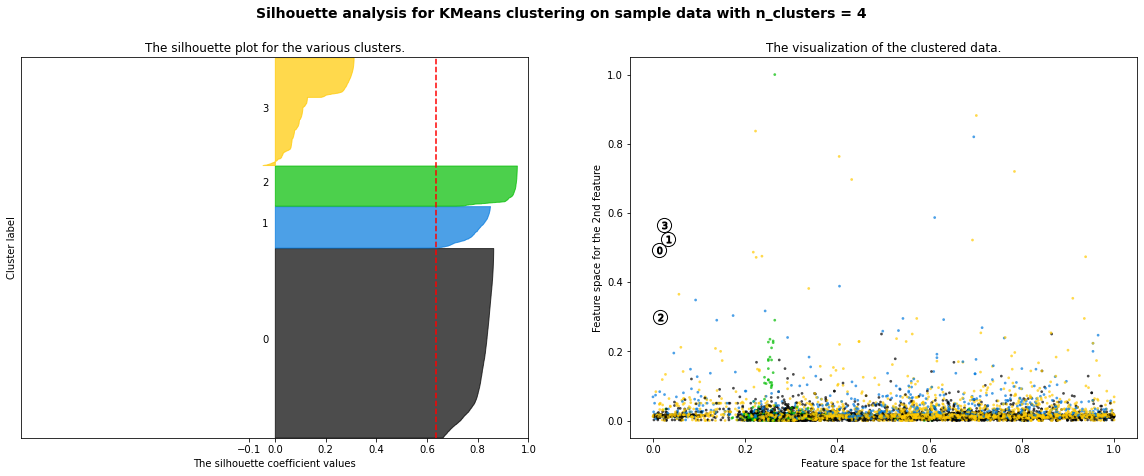

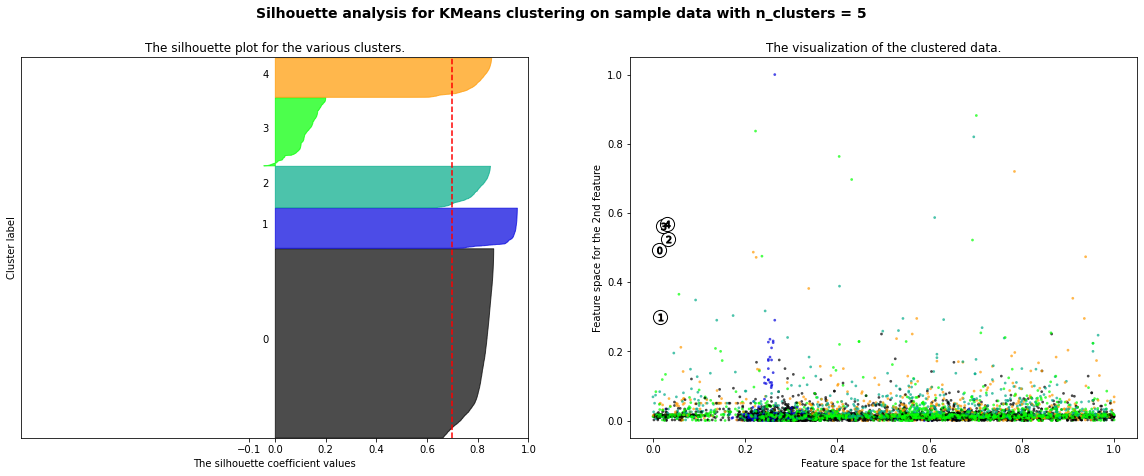

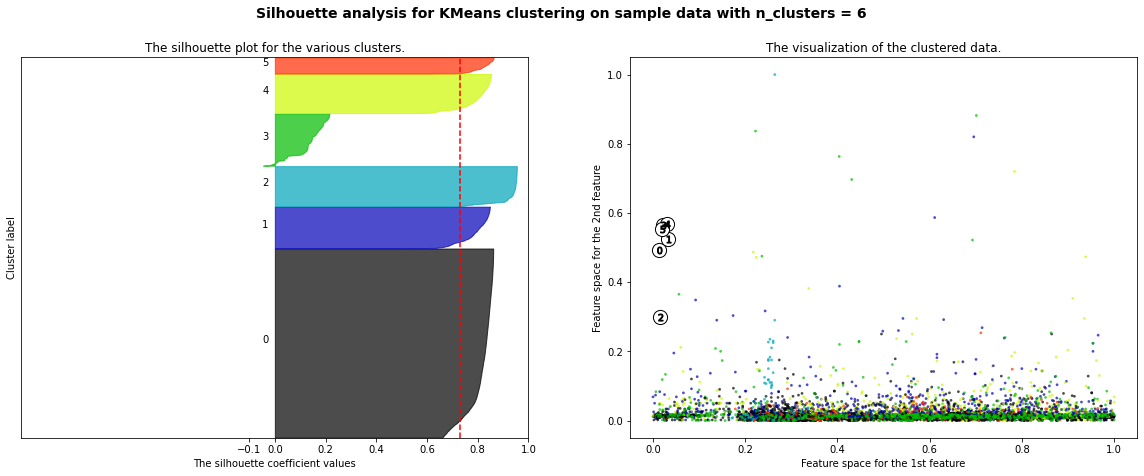

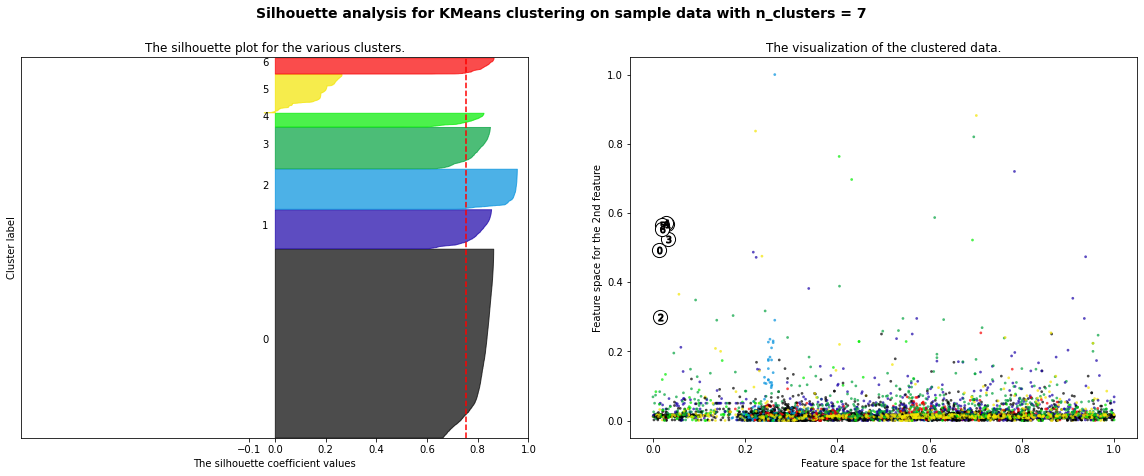

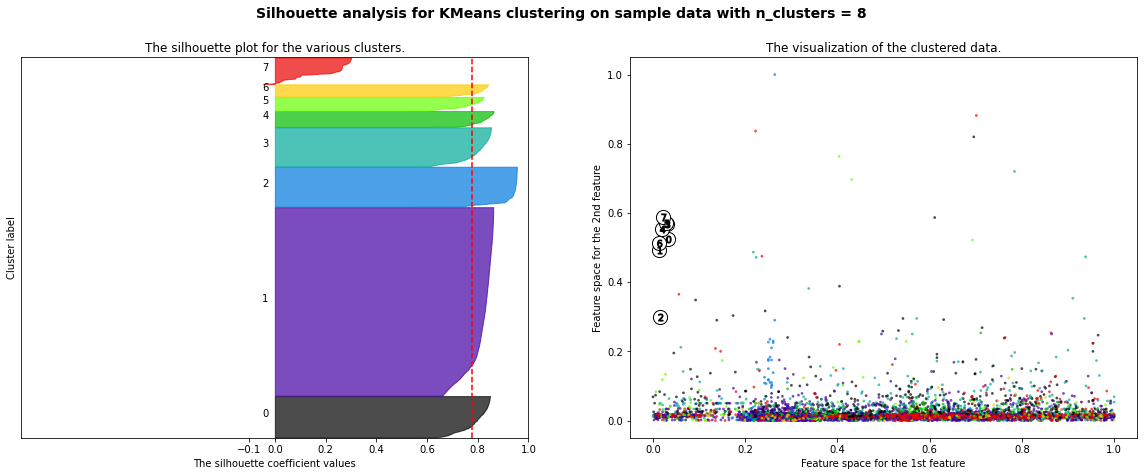

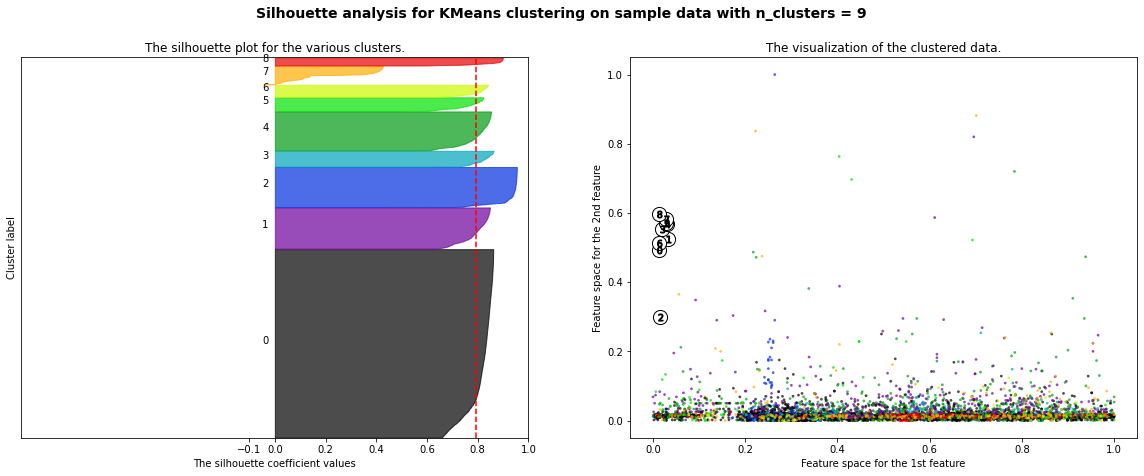

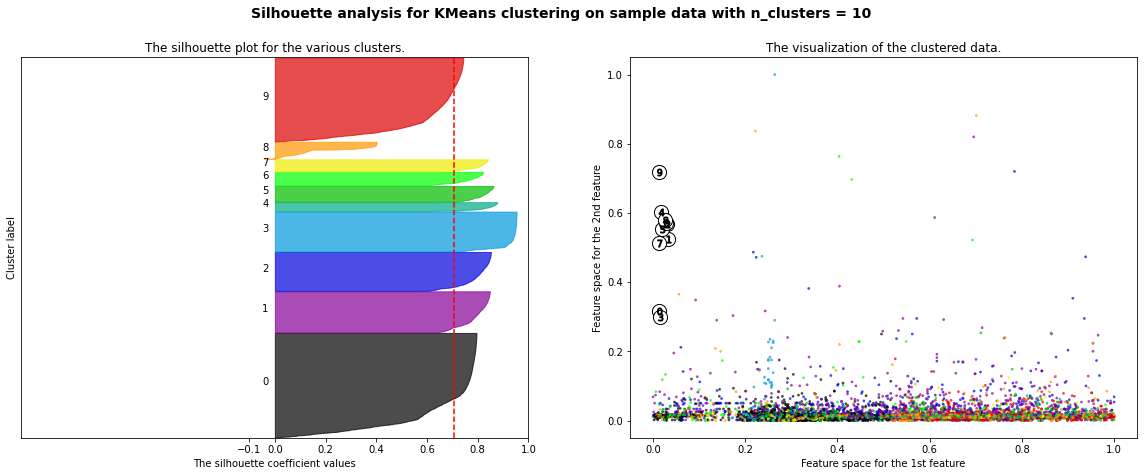

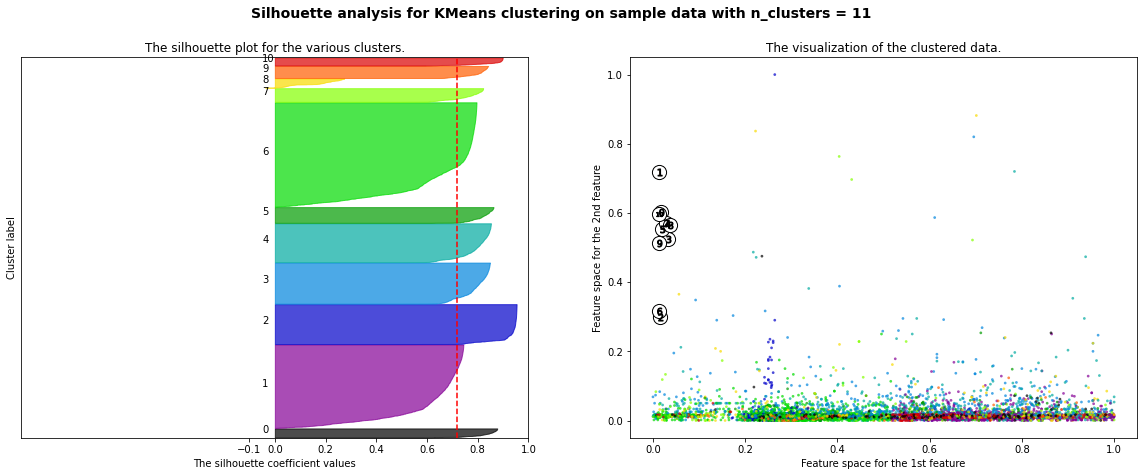

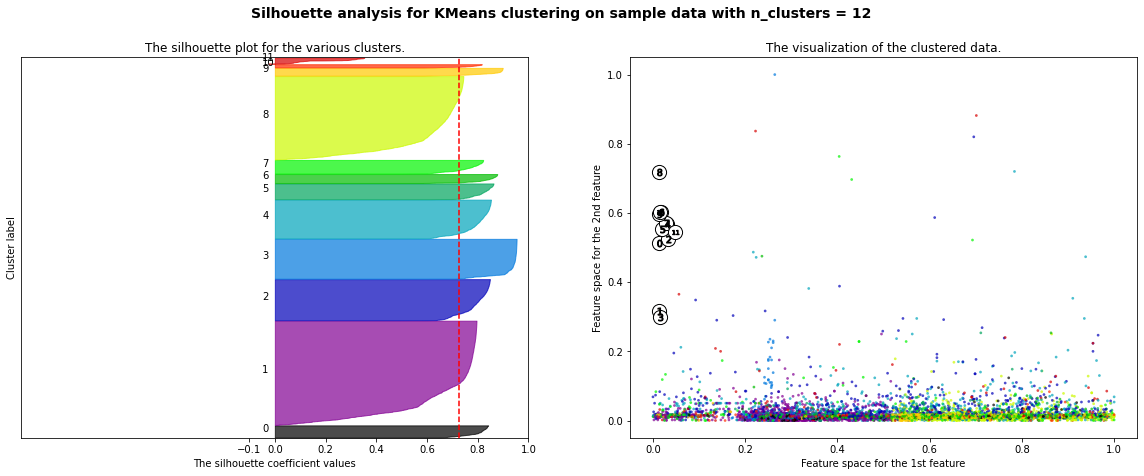

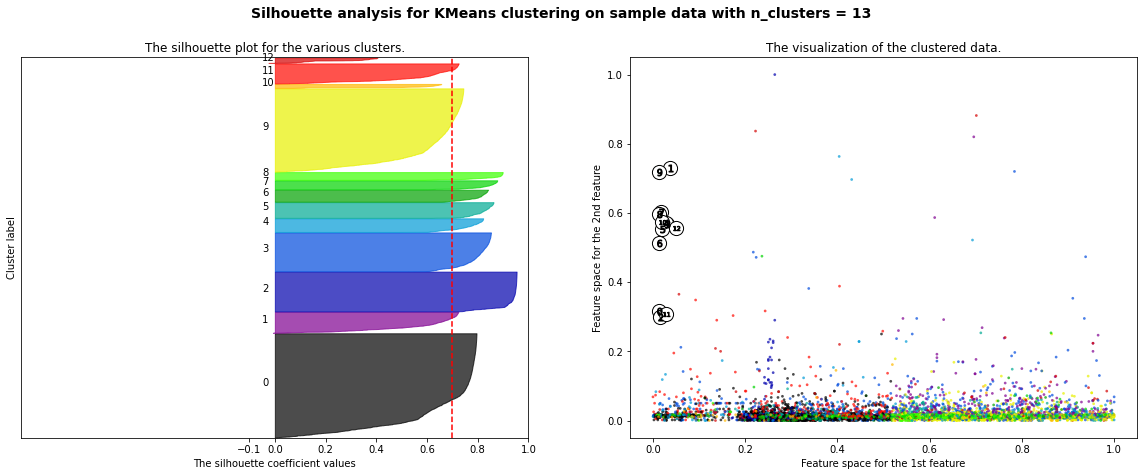

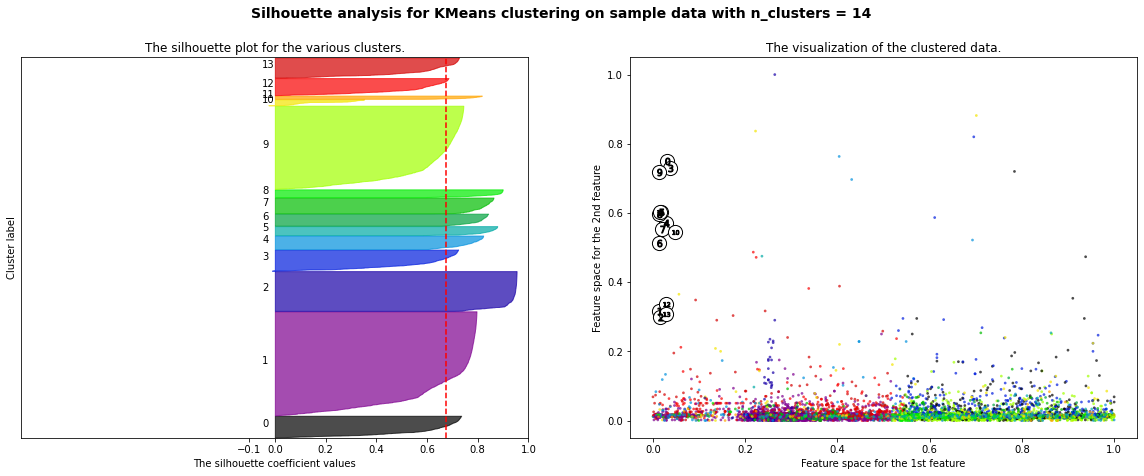

In [57]:
X, y = incident_dummy['Time_in_hours'], incident_dummy['Min_Delay']

for k in range(2,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(incident_dummy)
    cluster_labels = clusterer.predict(incident_dummy)
    
    silhouette_avg = silhouette_score(incident_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(incident_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        incident_dummy['Time_in_hours'], incident_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (day, location, incident)

In [38]:
DLI_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Min_Gap'], axis=1)
DLI_data

Day                        Location             Incident
0     Thursday         dundas_and_roncesvalles  late_leaving_garage
1     Thursday                   king_and_shaw   utilized_off_route
2     Thursday       kingston_road_and_bingham              held_by
3     Thursday  king_st._and_roncesvalles_ave.        investigation
4     Thursday               king_and_bathurst   utilized_off_route
...        ...                             ...                  ...
1012    Sunday                     gunn's_loop           mechanical
1013    Sunday             queen_and_broadview   emergency_services
1014    Sunday                king_and_spadina           mechanical
1016    Sunday                queen_and_church              held_by
1017    Sunday             spadina_and_college             cleaning

[8957 rows x 3 columns]

In [49]:
#encoded df
DLI_dummy = df

for i in DLI_data:
    dummies = pd.get_dummies(DLI_data[i])
    DLI_dummy = pd.concat([DLI_dummy, dummies], axis=1)
    DLI_dummy = DLI_dummy.drop(i, axis=1)

DLI_dummy = DLI_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route',
                            'Time_in_minutes','Direction', 'Min_Gap'], axis=1)

DLI_dummy['Min_Delay'] = (DLI_dummy['Min_Delay'] - DLI_dummy['Min_Delay'].min()) / (DLI_dummy['Min_Delay'].max() - DLI_dummy['Min_Delay'].min())
DLI_dummy['Time_in_hours'] = (DLI_dummy['Time_in_hours'] - DLI_dummy['Time_in_hours'].min()) / (DLI_dummy['Time_in_hours'].max() - DLI_dummy['Time_in_hours'].min())

DLI_dummy


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0      0.006667       0.271716       0       0         0       0         1   
1      0.033333       0.530229       0       0         0       0         1   
2      0.021667       0.584434       0       0         0       0         1   
3      0.011667       0.599027       0       0         0       0         1   
4      0.005000       0.696317       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012   0.008333       0.924253       0       0         0       1         0   
1013   0.018333       0.947186       0       0         0       1         0   
1014   0.005000       0.010424       0       0         0       1         0   
1016   0.021667       0.031967       0       0         0       1         0   
1017   0.020000       0.057679       0       0         0       1         0   

      Tuesday  Wednesday  1st_and_lakeshore  ...  investigation  late  \
0           0          0                  0  ...              0     0   
1           0          0                  0  ...              0     0   
2           0          0                  0  ...              0     0   
3           0          0                  0  ...              1     0   
4           0          0                  0  ...              0     0   
...       ...        ...                ...  ...            ...   ...   
1012        0          0                  0  ...              0     0   
1013        0          0                  0  ...              0     0   
1014        0          0                  0  ...              0     0   
1016        0          0                  0  ...              0     0   
1017        0          0                  0  ...              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
0                       1           0           0         0   
1                       0           0           0         0   
2                       0           0           0         0   
3                       0           0           0         0   
4                       0           0           0         0   
...                   ...         ...         ...       ...   
1012                    0           1           0         0   
1013                    0           0           0         0   
1014                    0           1           0         0   
1016                    0           0           0         0   
1017                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0                   1  
...                     ...            ...       ...                 ...  
1012                      0              0         0                   0  
1013                      0              0         0                   0  
1014                      0              0         0                   0  
1016                      0              0         0                   0  
1017                      0              0         0                   0  

[8957 rows x 2881 columns]

For k = 5 The average silhouette_score is : 0.12656011923040913
For k = 6 The average silhouette_score is : 0.18197242348730472
For k = 7 The average silhouette_score is : 0.20407815444497815
For k = 8 The average silhouette_score is : 0.19791486285937693
For k = 9 The average silhouette_score is : 0.18075643257122137
For k = 10 The average silhouette_score is : 0.16863032549666554
For k = 11 The average silhouette_score is : 0.1560656577412133
For k = 12 The average silhouette_score is : 0.1599243817033267
For k = 13 The average silhouette_score is : 0.16248332974482918
For k = 14 The average silhouette_score is : 0.16715875655128967


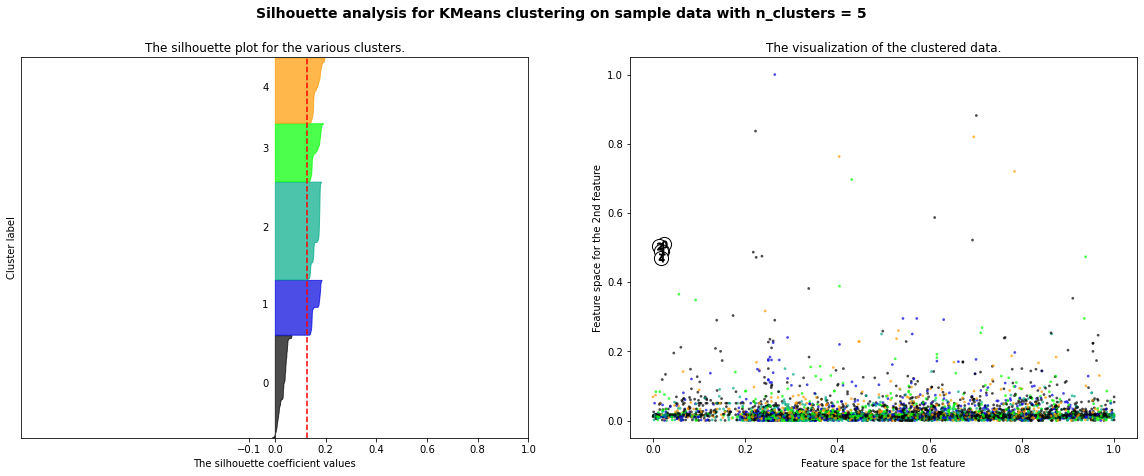

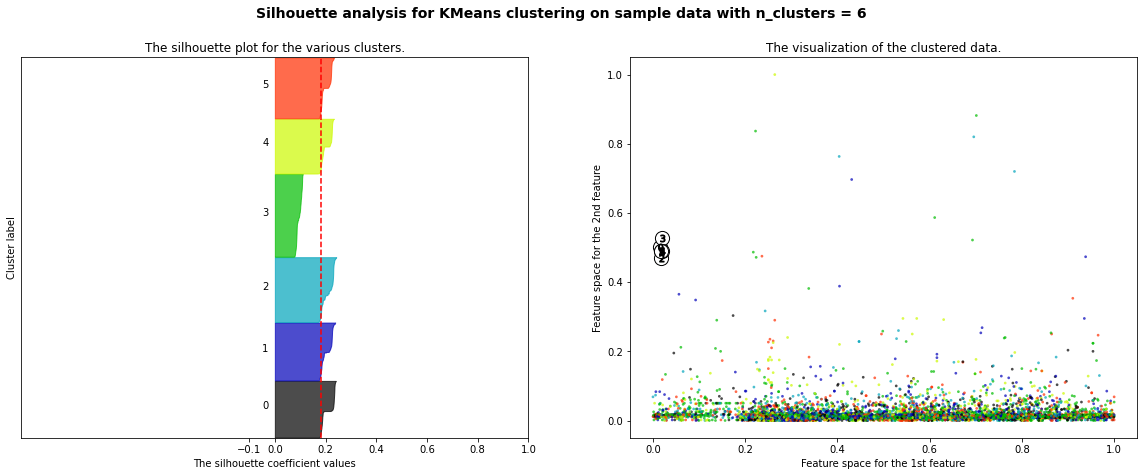

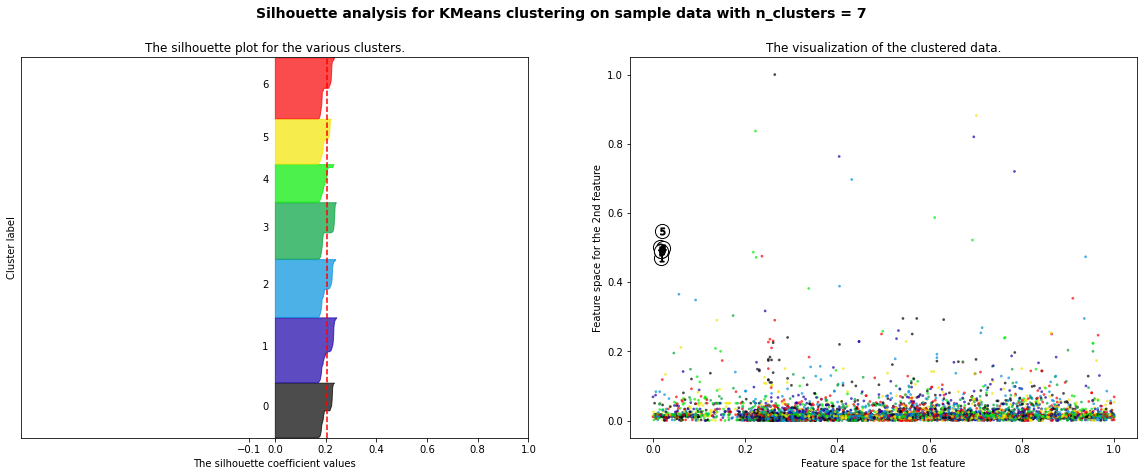

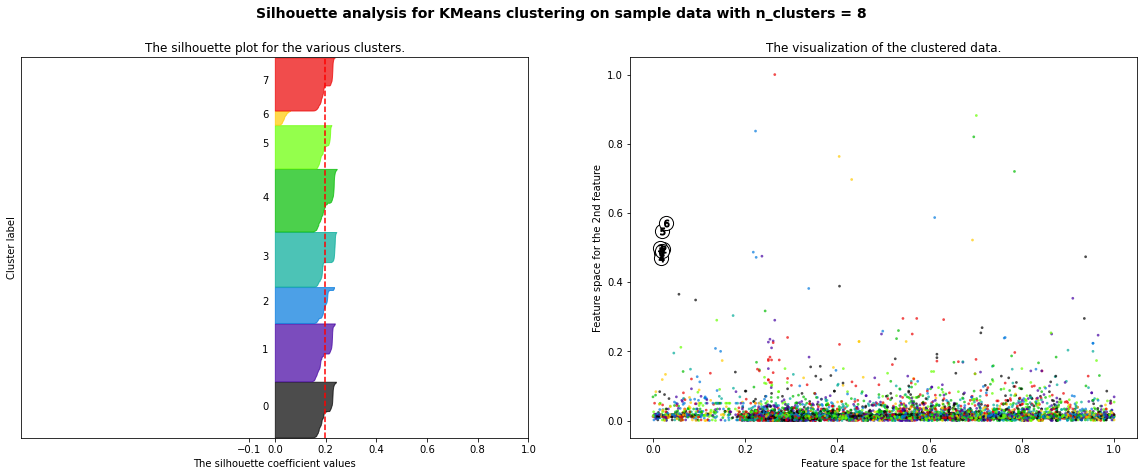

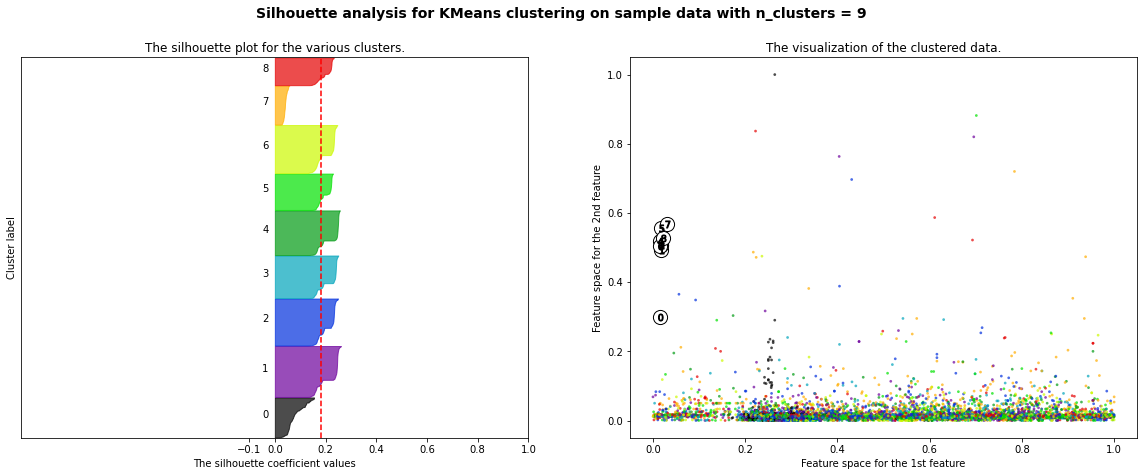

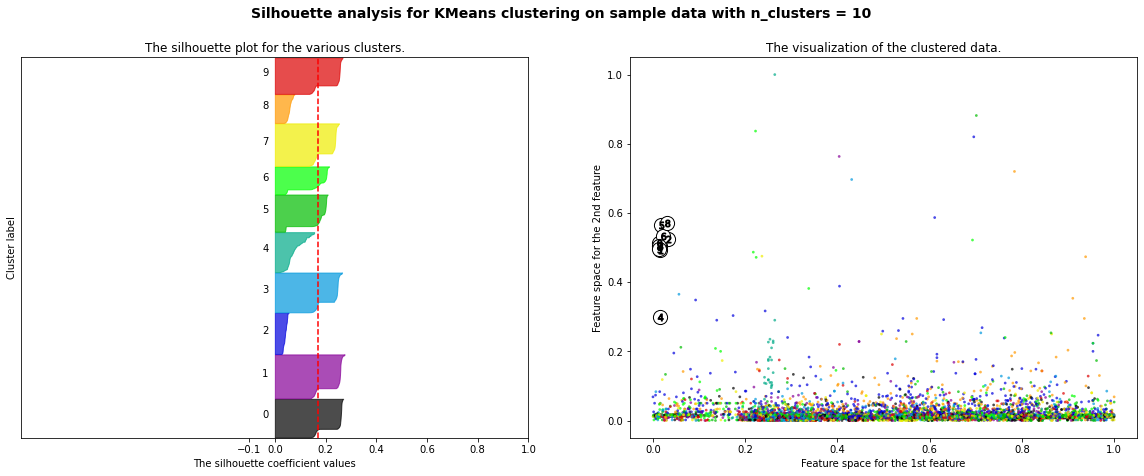

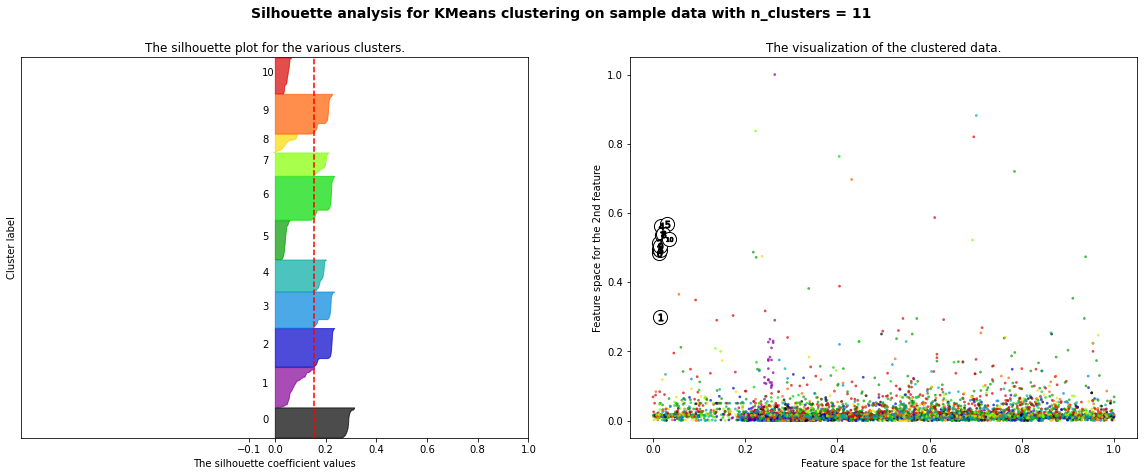

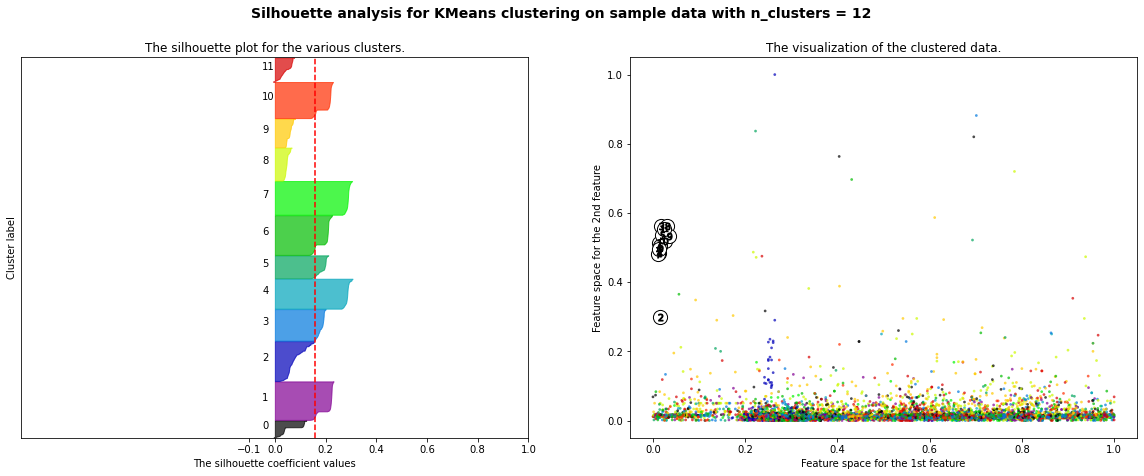

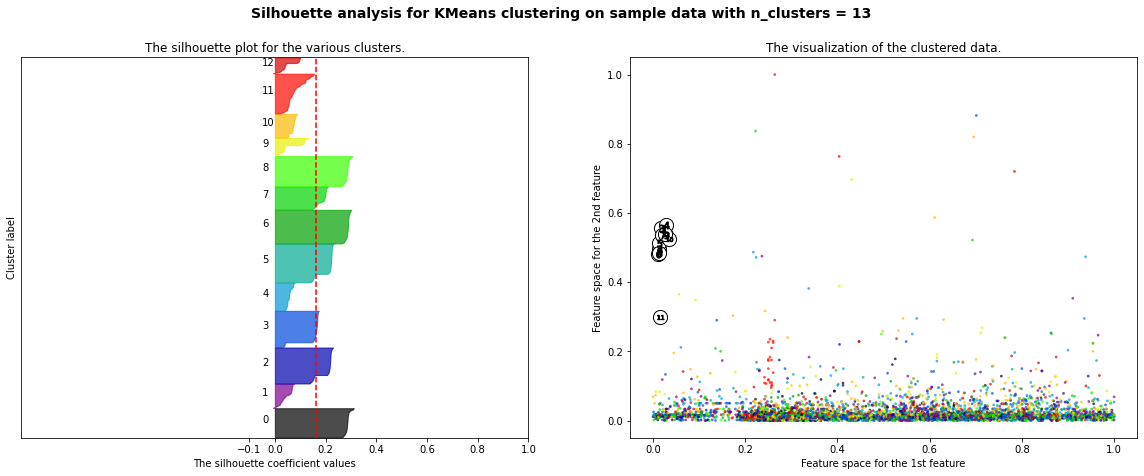

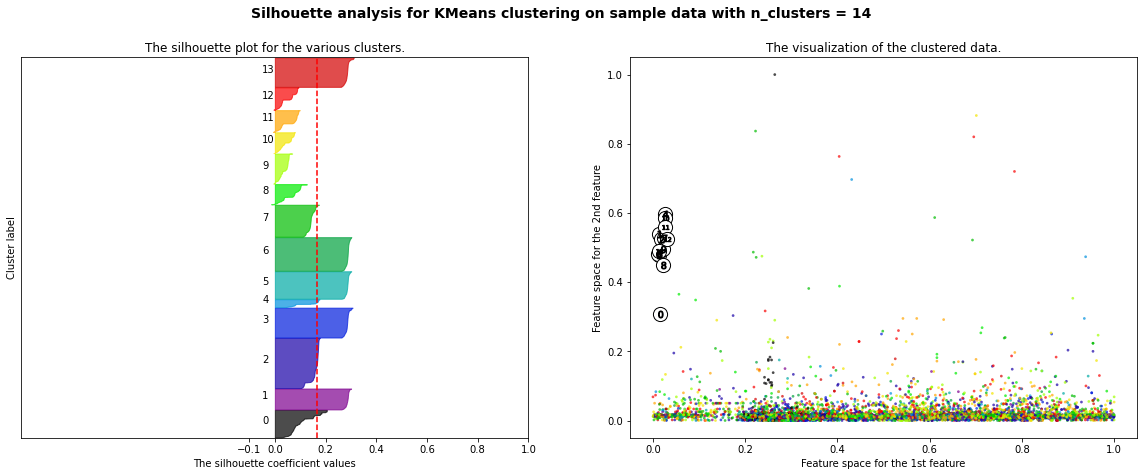

In [58]:
X, y = DLI_dummy['Time_in_hours'], DLI_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DLI_dummy)
    cluster_labels = clusterer.predict(DLI_dummy)
    
    silhouette_avg = silhouette_score(DLI_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(DLI_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        DLI_dummy['Time_in_hours'], DLI_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

In [47]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DLI_dummy)
    label = clusterer.predict(DLI_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(DLI_dummy, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
#location_dummy.groupby(best_label).mean()
sil_scores

k  silhouette_score                                              label
0   5          0.127660  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
1   6          0.130993  [3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, ...
2   7          0.204078  [6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, ...
3   8          0.191928  [6, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, ...
4   9          0.180756  [0, 8, 8, 3, 8, 8, 8, 3, 1, 1, 1, 1, 1, 1, 1, ...
5  10          0.168843  [0, 8, 2, 4, 8, 2, 8, 4, 6, 6, 6, 6, 6, 6, 6, ...
6  11          0.160750  [8, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, ...
7  12          0.159911  [2, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 1...
8  13          0.161566  [8, 3, 1, 11, 3, 1, 3, 11, 10, 2, 2, 2, 2, 2, ...
9  14          0.168517  [4, 4, 6, 4, 4, 6, 4, 4, 13, 1, 1, 1, 1, 1, 1,...

### K-Means (day and incident)

In [67]:
DI_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Location',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Min_Gap'], axis=1)
DI_data

Day             Incident
0     Thursday  late_leaving_garage
1     Thursday   utilized_off_route
2     Thursday              held_by
3     Thursday        investigation
4     Thursday   utilized_off_route
...        ...                  ...
1012    Sunday           mechanical
1013    Sunday   emergency_services
1014    Sunday           mechanical
1016    Sunday              held_by
1017    Sunday             cleaning

[8957 rows x 2 columns]

In [69]:
#encoded df
DI_dummy = df

for i in DI_data:
    dummies = pd.get_dummies(DI_data[i])
    DI_dummy = pd.concat([DI_dummy, dummies], axis=1)
    DI_dummy = DI_dummy.drop(i, axis=1)

DI_dummy = DI_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route',
                          'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

DI_dummy['Min_Delay'] = (DI_dummy['Min_Delay'] - DI_dummy['Min_Delay'].min()) / (DI_dummy['Min_Delay'].max() - DI_dummy['Min_Delay'].min())
DI_dummy['Time_in_hours'] = (DI_dummy['Time_in_hours'] - DI_dummy['Time_in_hours'].min()) / (DI_dummy['Time_in_hours'].max() - DI_dummy['Time_in_hours'].min())

DI_dummy


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0      0.006667       0.271716       0       0         0       0         1   
1      0.033333       0.530229       0       0         0       0         1   
2      0.021667       0.584434       0       0         0       0         1   
3      0.011667       0.599027       0       0         0       0         1   
4      0.005000       0.696317       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012   0.008333       0.924253       0       0         0       1         0   
1013   0.018333       0.947186       0       0         0       1         0   
1014   0.005000       0.010424       0       0         0       1         0   
1016   0.021667       0.031967       0       0         0       1         0   
1017   0.020000       0.057679       0       0         0       1         0   

      Tuesday  Wednesday  cleaning  ...  investigation  late  \
0           0          0         0  ...              0     0   
1           0          0         0  ...              0     0   
2           0          0         0  ...              0     0   
3           0          0         0  ...              1     0   
4           0          0         0  ...              0     0   
...       ...        ...       ...  ...            ...   ...   
1012        0          0         0  ...              0     0   
1013        0          0         0  ...              0     0   
1014        0          0         0  ...              0     0   
1016        0          0         0  ...              0     0   
1017        0          0         1  ...              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
0                       1           0           0         0   
1                       0           0           0         0   
2                       0           0           0         0   
3                       0           0           0         0   
4                       0           0           0         0   
...                   ...         ...         ...       ...   
1012                    0           1           0         0   
1013                    0           0           0         0   
1014                    0           1           0         0   
1016                    0           0           0         0   
1017                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0                   1  
...                     ...            ...       ...                 ...  
1012                      0              0         0                   0  
1013                      0              0         0                   0  
1014                      0              0         0                   0  
1016                      0              0         0                   0  
1017                      0              0         0                   0  

[8957 rows x 25 columns]

In [70]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DI_dummy)
    label = clusterer.predict(DI_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(DI_dummy, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
#location_dummy.groupby(best_label).mean()
sil_scores

k  silhouette_score                                              label
0   5          0.272823  [3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, ...
1   6          0.310627  [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, ...
2   7          0.339196  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...
3   8          0.398730  [6, 6, 6, 0, 6, 6, 6, 0, 7, 7, 7, 7, 7, 7, 7, ...
4   9          0.399216  [8, 4, 0, 4, 4, 0, 4, 4, 3, 3, 3, 3, 3, 3, 3, ...
5  10          0.405581  [2, 8, 0, 3, 8, 0, 8, 3, 4, 4, 4, 4, 4, 4, 4, ...
6  11          0.407265  [3, 10, 7, 9, 10, 7, 10, 9, 1, 5, 5, 5, 5, 5, ...
7  12          0.442173  [8, 8, 8, 8, 8, 8, 8, 8, 2, 9, 9, 9, 9, 9, 9, ...
8  13          0.434467  [9, 10, 0, 10, 10, 0, 10, 10, 2, 8, 8, 8, 8, 8...
9  14          0.460988  [7, 2, 2, 3, 2, 2, 2, 3, 13, 10, 10, 10, 10, 1...

For k = 5 The average silhouette_score is : 0.27595941918883704
For k = 6 The average silhouette_score is : 0.3072322320967829
For k = 7 The average silhouette_score is : 0.3507977364198367
For k = 8 The average silhouette_score is : 0.37445858079229116
For k = 9 The average silhouette_score is : 0.3982540605127756
For k = 10 The average silhouette_score is : 0.40630431390101646
For k = 11 The average silhouette_score is : 0.4057477695398021
For k = 12 The average silhouette_score is : 0.4435786273825808
For k = 13 The average silhouette_score is : 0.44369445904761196
For k = 14 The average silhouette_score is : 0.4754189852227949


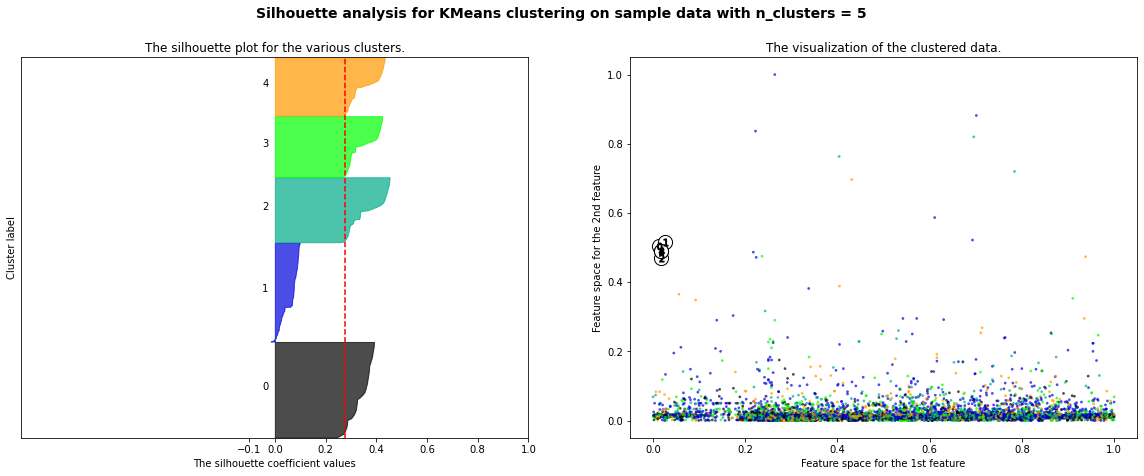

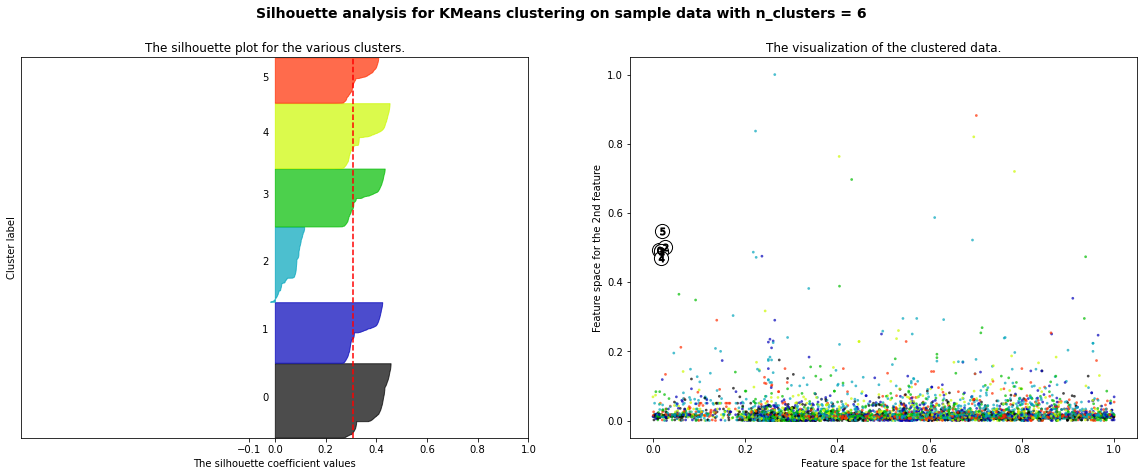

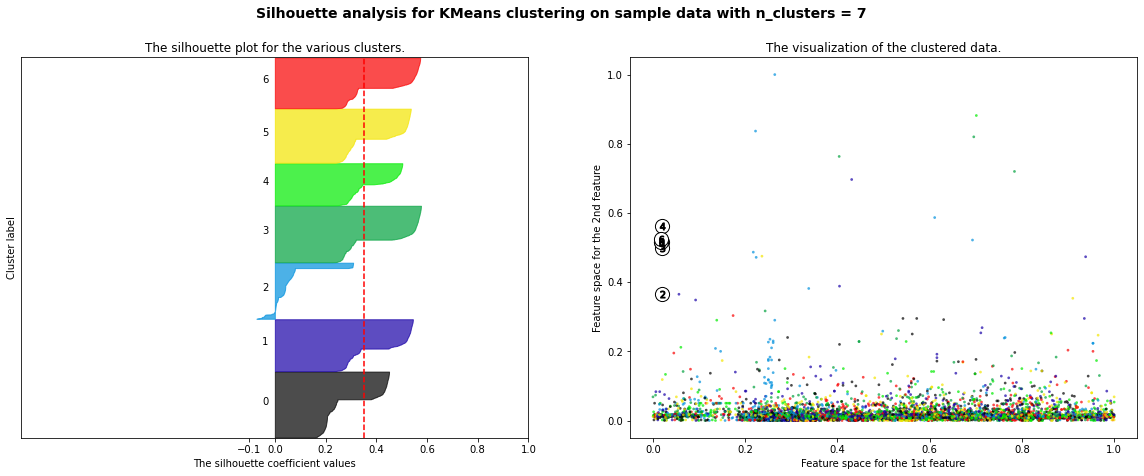

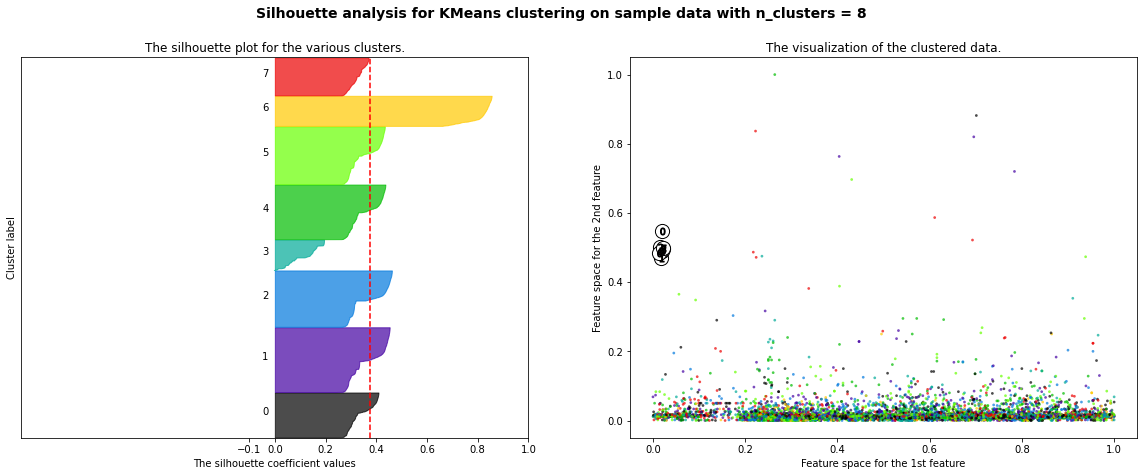

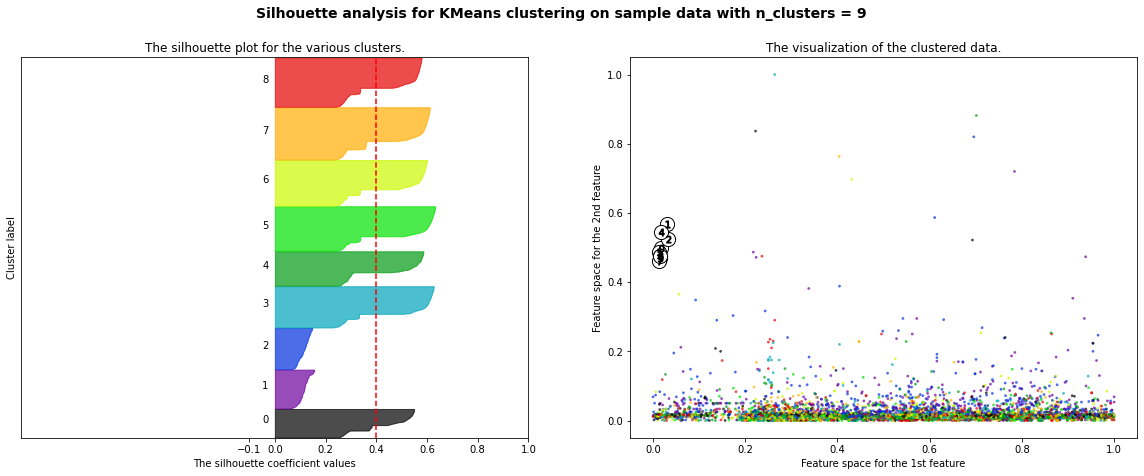

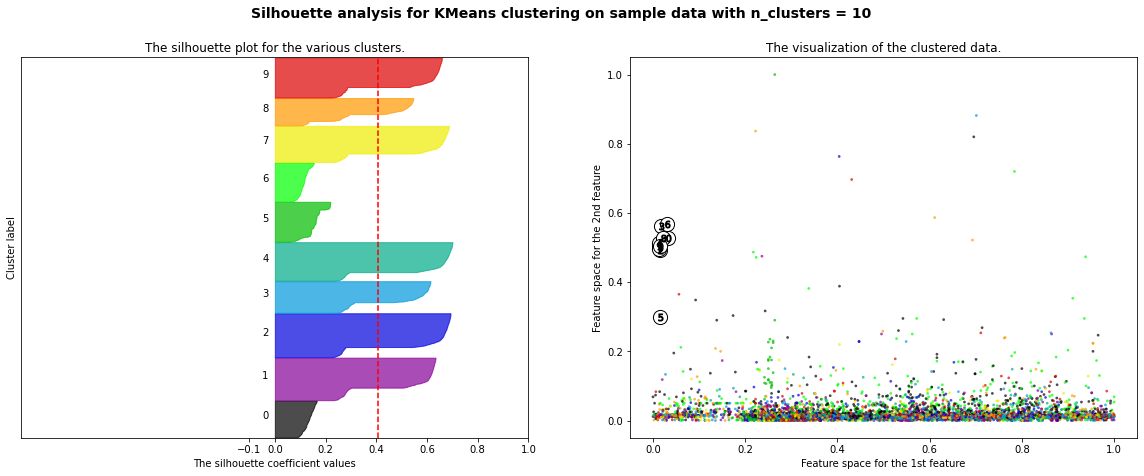

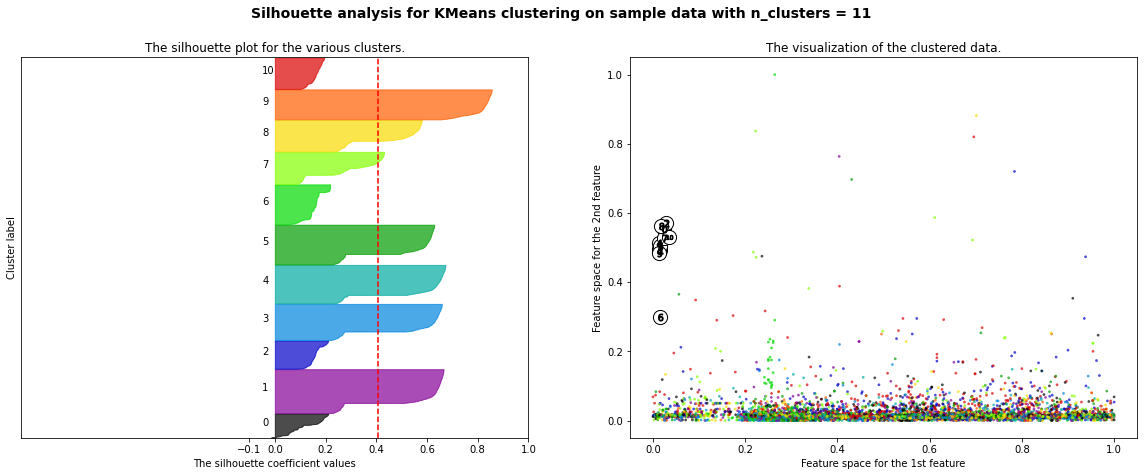

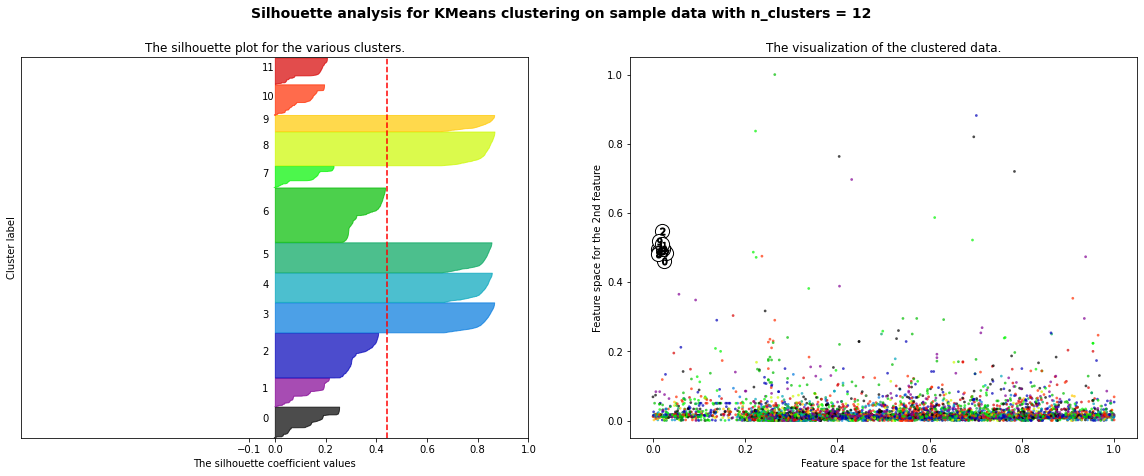

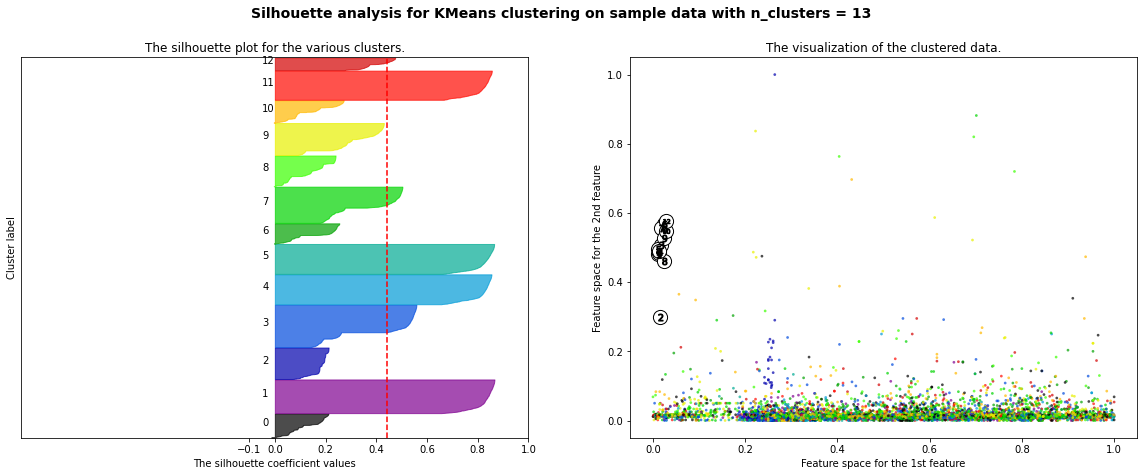

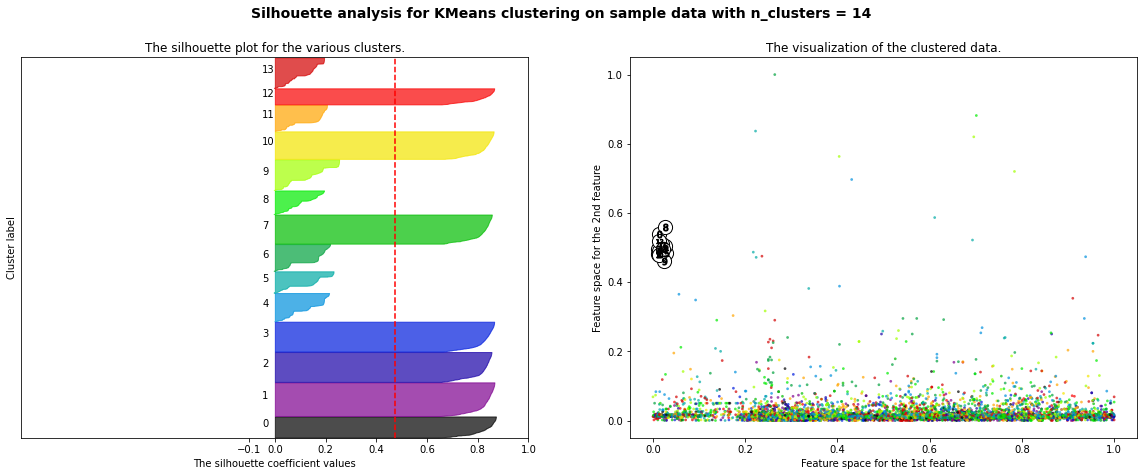

In [71]:
X, y = DI_dummy['Time_in_hours'], DI_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DI_dummy)
    cluster_labels = clusterer.predict(DI_dummy)
    
    silhouette_avg = silhouette_score(DI_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(DI_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        DI_dummy['Time_in_hours'], DI_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    